<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

<b><h2>Project Nature & Content: Computer Vision</h2></b>

<b><h3>Motivation and Background Documentation</h3></b>
The primary intent of this assignment is to give you hands-on, practical experience with understanding the transition from simple (single hidden layer) to deep (multiple hidden layers) networks.

This hinges on understanding how hidden nodes learn to extract features from their inputs. When there are multiple hidden node layers, each successive layer extracts more generalized and abstract features.

When a hidden layer "learns" the kinds of features that are inherent in its input data, it is using a generative method. In this case, we're not telling it what those feature classes are; it has to figure them out on its own.  

What we will pragmatically do is emulate how a hidden layer learns features by constructing "classes" of input data - where we think that the classes share similar features. We'll put input data into those classes that we THINK have similar features. Then, we conduct experiments to determine what the hidden nodes are actually learning.

You will have gathered and preprocessed your data, designed and refined your network structure, trained and tested the network, varied the hyperparameters to improve performance and analyzed/assessed the results.

The most important thing is not just to give a summary of classification rates/errors. I trust that you can get a working classifier, or can train a network to do any useful task.

<b>You are welcome to use the CIFAR-10 data for this exercise.</b> You are welcome to use Python with user-defined functions, Python with TensorFlow, and/or Python with Keras. For example, you can conduct the following experiments on the CIFAR-10 data. The goal is to compare DNN and CNN architectures. In all the experiments, you may hold some parameters constants - for example, the batch size to 100, the number of epochs to 20, same optimizer, same loss function of cross entropy, so that the comparisons are fair.

<b>Experiment 1:</b> DNN with 2 layers (no regularization)

<b>Experiment 2:</b> DNN with 3 layers (no regularization)

<b>Experiment 3:</b> CNN with 2 convolution/max pooling layers (no regularization)

<b>Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

<b>Experiment 5+ :</b> You will conduct several more experiments. (a) Redo all the 4 experiments with some regularization technique. (b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

<b>Result1:</b>  Create a table with the accuracy and loss for train/test/validation & process time for ALL the models.

<b>Result2:</b> Take Experiment 3 – Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

## Import packages needed

In [4]:
import numpy as np
import time
import pandas as pd
from packaging import version
from collections import Counter
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
# from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.python.client import device_lib
import warnings
warnings.filterwarnings('ignore')

In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Verify TensorFlow Version and Keras Version

In [6]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


In [7]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

## EDA Functions

In [8]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [9]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [10]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


## EDA

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

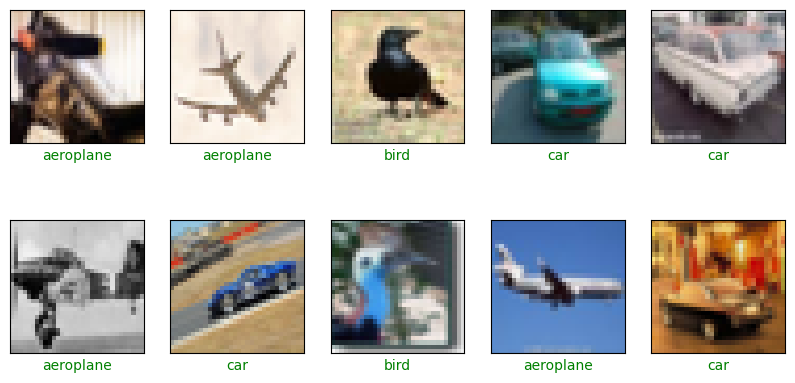

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

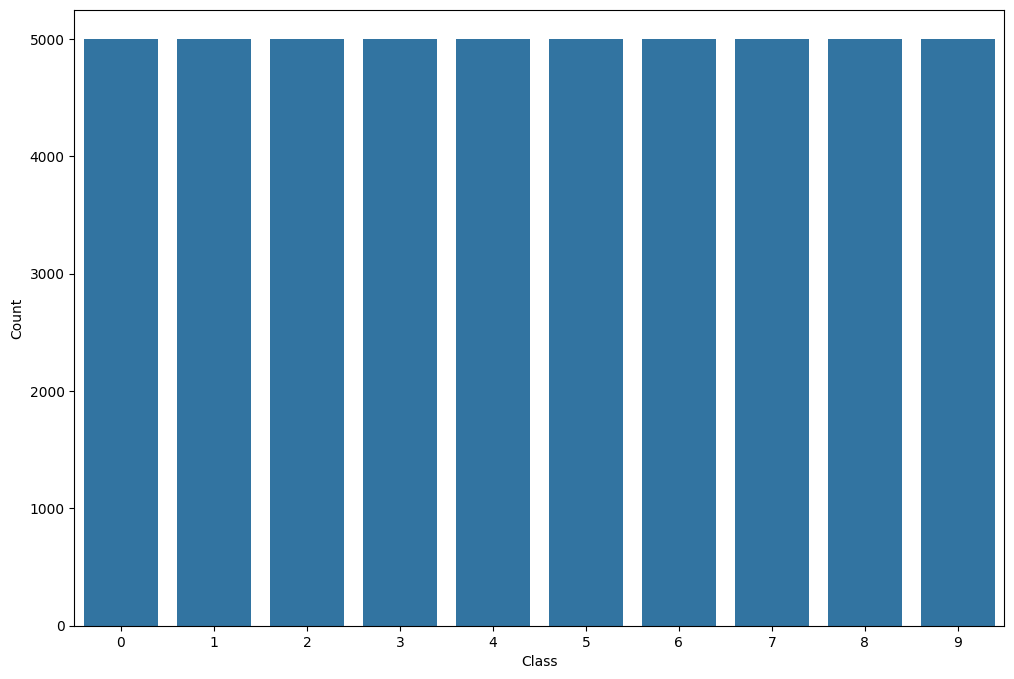

In [17]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels.ravel()).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [18]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [19]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=seed_val
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [20]:
print("Training\t", x_train_split.shape,
      "\nValidation\t", x_valid_split.shape,
      "\nTest\t\t", x_test.shape)

Training	 (45000, 32, 32, 3) 
Validation	 (5000, 32, 32, 3) 
Test		 (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255


1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [21]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/CNN_architecture_v4.png?raw=1">

In [22]:
results = {}

## **Experiment 1:**
- DNN with 2 layers
- no regularization

##### Build CNN Model

In [23]:
k.clear_session()
model_01 = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=768,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment1"] = {}
results["Experiment1"]["Architecture"] = "• DNN with 2 layers\n • no regularization"

2024-10-20 03:42:39.377699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


In [24]:
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 10)                7690      
                                                                 
Total params: 1483402 (5.66 MB)
Trainable params: 1483402 (5.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
keras.utils.plot_model(model_01, "CIFAR10_EXP_01.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
model_01.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [27]:
# Start time
start_time = time.time()

history_01 = model_01.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_01_2DNN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment1"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200


2024-10-20 03:42:41.986097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdc641c7bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-20 03:42:41.986130: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-10-20 03:42:42.004663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-20 03:42:42.038574: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1729395762.154273    4048 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 [==============================] - 3s 2ms/step - loss: 1.8620 - accuracy: 0.3257 - val_loss: 1.7651 - val_accuracy: 0.3610
Epoch 2/200
704/704 [==============================] - 1s 2ms/step - loss: 1.6743 - accuracy: 0.3978 - val_loss: 1.6542 - val_accuracy: 0.4146
Epoch 3/200
704/704 [==============================] - 1s 2ms/step - loss: 1.5933 - accuracy: 0.4304 - val_loss: 1.6508 - val_accuracy: 0.4144
Epoch 4/200
704/704 [==============================] - 1s 2ms/step - loss: 1.5277 - accuracy: 0.4515 - val_loss: 1.5871 - val_accuracy: 0.4398
Epoch 5/200
704/704 [==============================] - 1s 2ms/step - loss: 1.4943 - accuracy: 0.4641 - val_loss: 1.5559 - val_accuracy: 0.4500
Epoch 6/200
704/704 [==============================] - 1s 2ms/step - loss: 1.4663 - accuracy: 0.4741 - val_loss: 1.5530 - val_accuracy: 0.4480
Epoch 7/200
704/704 [==============================] - 1s 2ms/step - loss: 1.4398 - accuracy: 0.4827 - val_loss: 1.5217 - val_accuracy: 0.4706
Epoch 8/200

In [28]:
train_loss = history_01.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_01.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_01.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_01.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_01 = tf.keras.models.load_model("A2_Exp_01_2DNN.h5")
test_loss, test_accuracy = model_01.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment1"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment1"]["Test Loss"] = round(test_loss,3)
results["Experiment1"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment1"]["Train Loss"] = round(train_loss,3)
results["Experiment1"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment1"]["Validation Loss"] = round(val_loss,3)

Training Loss: 1.311, Training Accuracy: 0.530
Validation Loss: 1.550, Validation Accuracy: 0.461
Test Loss: 1.478, Test Accuracy: 0.474


In [29]:
pred01 = model_01.predict(x_test_norm)
print('shape of preds: ', pred01.shape)

history_01_dict = history_01.history
history_01_dict.keys()

313/313 [==============================] - 1s 911us/step
shape of preds:  (10000, 10)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history__01_df=pd.DataFrame(history_01_dict)
history__01_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
9   1.376     0.508     1.547         0.456
10  1.357     0.514     1.537         0.462
11  1.338     0.518     1.528         0.465
12  1.325     0.524     1.539         0.462
13  1.311     0.530     1.550         0.461

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

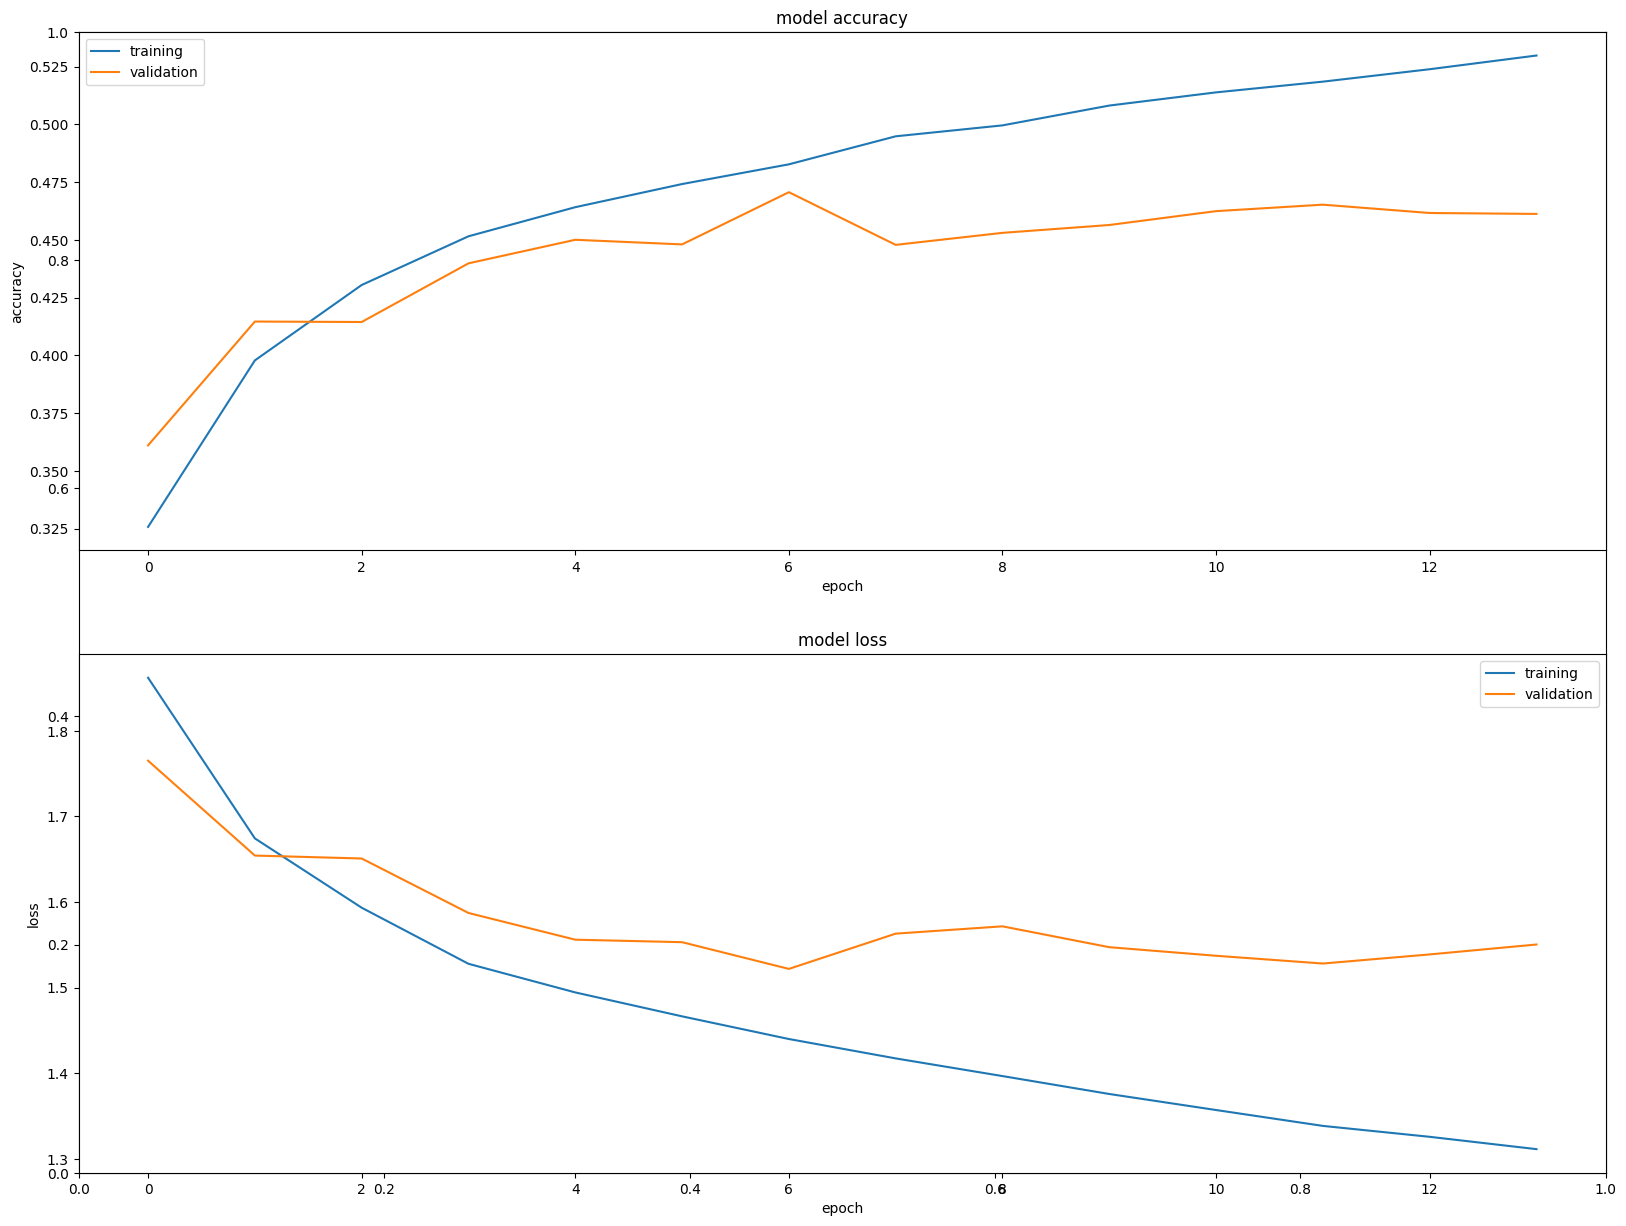

In [31]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_01.history['accuracy'], history_01.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_01.history['loss'], history_01.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [32]:
pred01_cm=np.argmax(pred01, axis=1)
print_validation_report(y_test, pred01_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.47      0.51      1000
           1       0.64      0.51      0.57      1000
           2       0.38      0.27      0.32      1000
           3       0.34      0.30      0.32      1000
           4       0.42      0.34      0.38      1000
           5       0.40      0.33      0.36      1000
           6       0.44      0.65      0.53      1000
           7       0.49      0.57      0.53      1000
           8       0.52      0.73      0.61      1000
           9       0.52      0.57      0.54      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000

Accuracy Score: 0.4743
Root Mean Square Error: 3.190235101054466


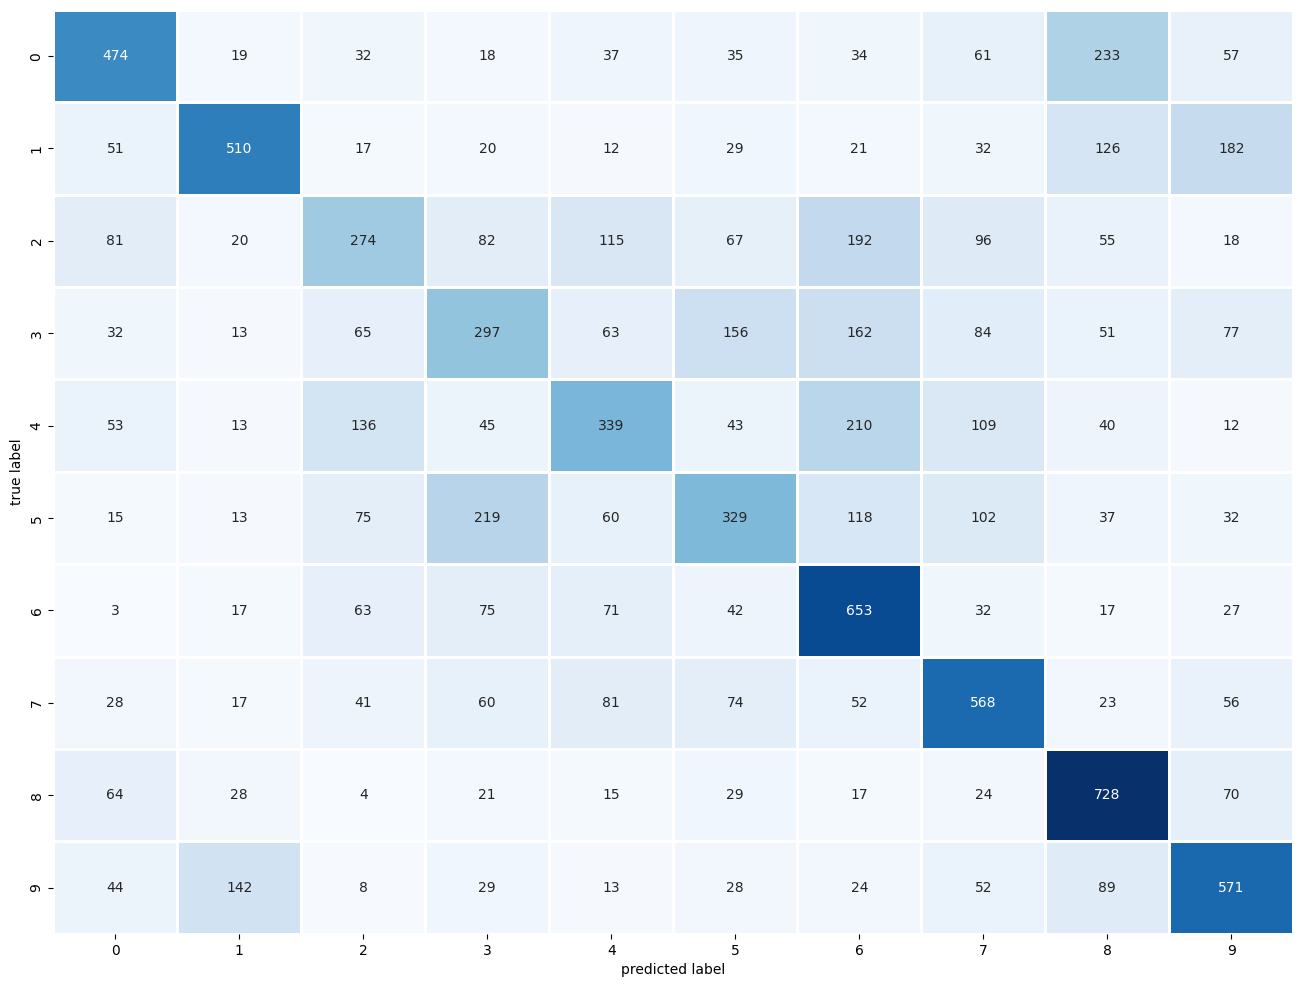

In [33]:
plot_confusion_matrix(y_test,pred01_cm)

In [34]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred01[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [35]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_01.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_01 = tf.keras.models.Model(inputs=model_01.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations_01 = activation_model_01.predict(x_valid_norm[:2000])
dense_layer_activations_01 = activations_01[-3]
output_layer_activations_01 = activations_01[-1]

63/63 [==============================] - 0s 873us/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [36]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_01 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_01 = tsne_01.fit_transform(dense_layer_activations_01)

# Scaling
tsne_results_01 = (tsne_results_01 - tsne_results_01.min()) / (tsne_results_01.max() - tsne_results_01.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 4.205060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.325455
[t-SNE] KL divergence after 300 iterations: 2.298152


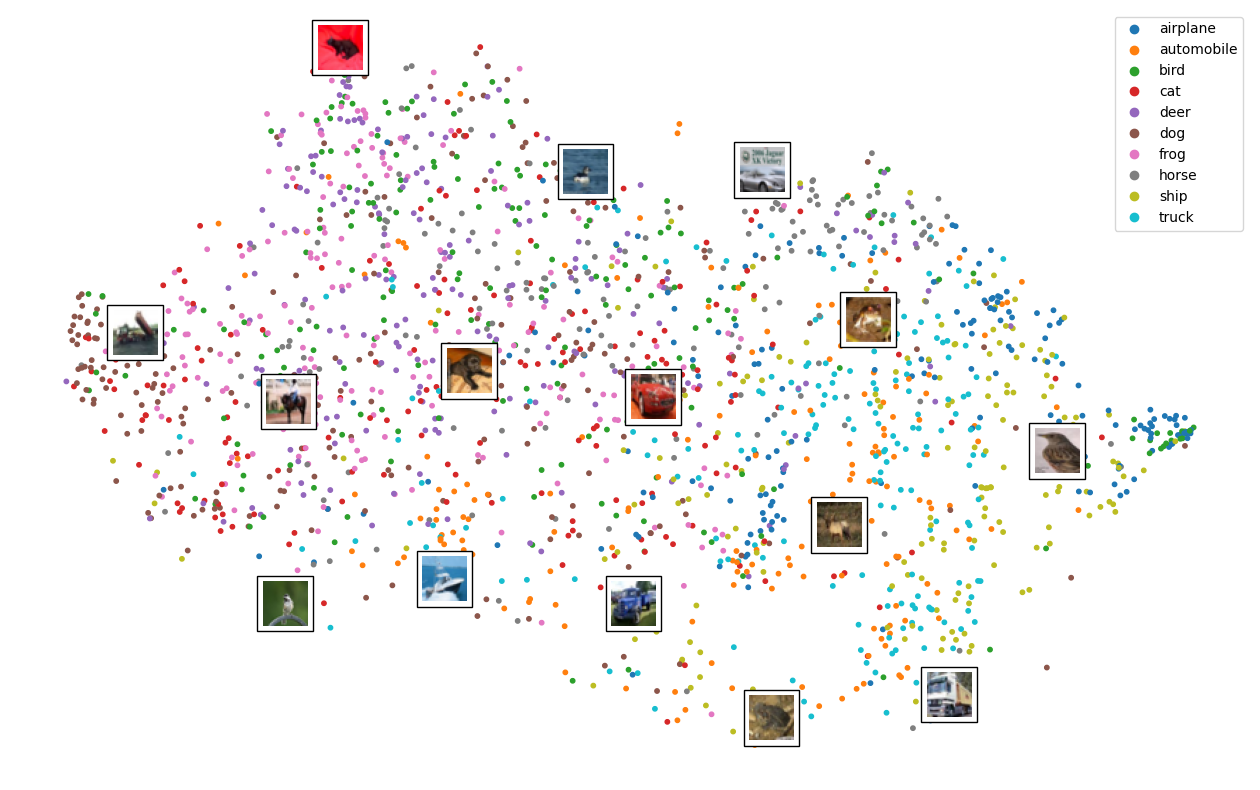

In [37]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_01[:,0],tsne_results_01[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_01[:,0],tsne_results_01[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_01):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 2**

- DNN with 3 layers
- no regularization

##### Build CNN Model

In [38]:
k.clear_session()
model_02 = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=768,activation=tf.nn.relu),
  Dense(units=1536,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment2"] = {}
results["Experiment2"]["Architecture"] = "• DNN with 3 layers\n • no regularization"

In [39]:
model_02.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 dense_2 (Dense)             (None, 1536)              1181184   
                                                                 
 dense_3 (Dense)             (None, 10)                15370     
                                                                 
Total params: 2672266 (10.19 MB)
Trainable params: 2672266 (10.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
keras.utils.plot_model(model_02, "CIFAR10_EXP_02.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
model_02.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [42]:
# Start time
start_time = time.time()
history_02 = model_02.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_02_3DNN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment2"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 3s 2ms/step - loss: 1.8682 - accuracy: 0.3207 - val_loss: 1.8131 - val_accuracy: 0.3428
Epoch 2/200
704/704 [==============================] - 2s 2ms/step - loss: 1.6875 - accuracy: 0.3922 - val_loss: 1.6631 - val_accuracy: 0.4002
Epoch 3/200
704/704 [==============================] - 2s 2ms/step - loss: 1.6053 - accuracy: 0.4210 - val_loss: 1.6479 - val_accuracy: 0.4274
Epoch 4/200
704/704 [==============================] - 2s 2ms/step - loss: 1.5433 - accuracy: 0.4454 - val_loss: 1.6016 - val_accuracy: 0.4276
Epoch 5/200
704/704 [==============================] - 2s 2ms/step - loss: 1.5096 - accuracy: 0.4591 - val_loss: 1.5565 - val_accuracy: 0.4464
Epoch 6/200
704/704 [==============================] - 2s 2ms/step - loss: 1.4642 - accuracy: 0.4721 - val_loss: 1.5056 - val_accuracy: 0.4610
Epoch 7/200
704/704 [==============================] - 1s 2ms/step - loss: 1.4304 - accuracy: 0.4871 - val_loss: 1.5461 - val_accuracy: 0.4504

In [43]:
train_loss = history_02.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_02.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_02.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_02.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_02 = tf.keras.models.load_model("A2_Exp_02_3DNN.h5")
test_loss, test_accuracy = model_02.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment2"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment2"]["Test Loss"] = round(test_loss,3)
results["Experiment2"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment2"]["Train Loss"] = round(train_loss,3)
results["Experiment2"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment2"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.655, Training Accuracy: 0.762
Validation Loss: 2.307, Validation Accuracy: 0.454
Test Loss: 1.466, Test Accuracy: 0.474


In [44]:
pred02 = model_02.predict(x_test_norm)
print('shape of preds: ', pred02.shape)

history_02_dict = history_02.history
history_02_df=pd.DataFrame(history_02_dict)
history_02_df.tail().round(3)

313/313 [==============================] - 0s 896us/step
shape of preds:  (10000, 10)


loss  accuracy  val_loss  val_accuracy
18  0.895     0.673     1.862         0.470
19  0.824     0.699     1.970         0.461
20  0.766     0.722     2.027         0.455
21  0.708     0.743     2.181         0.456
22  0.655     0.762     2.307         0.454

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

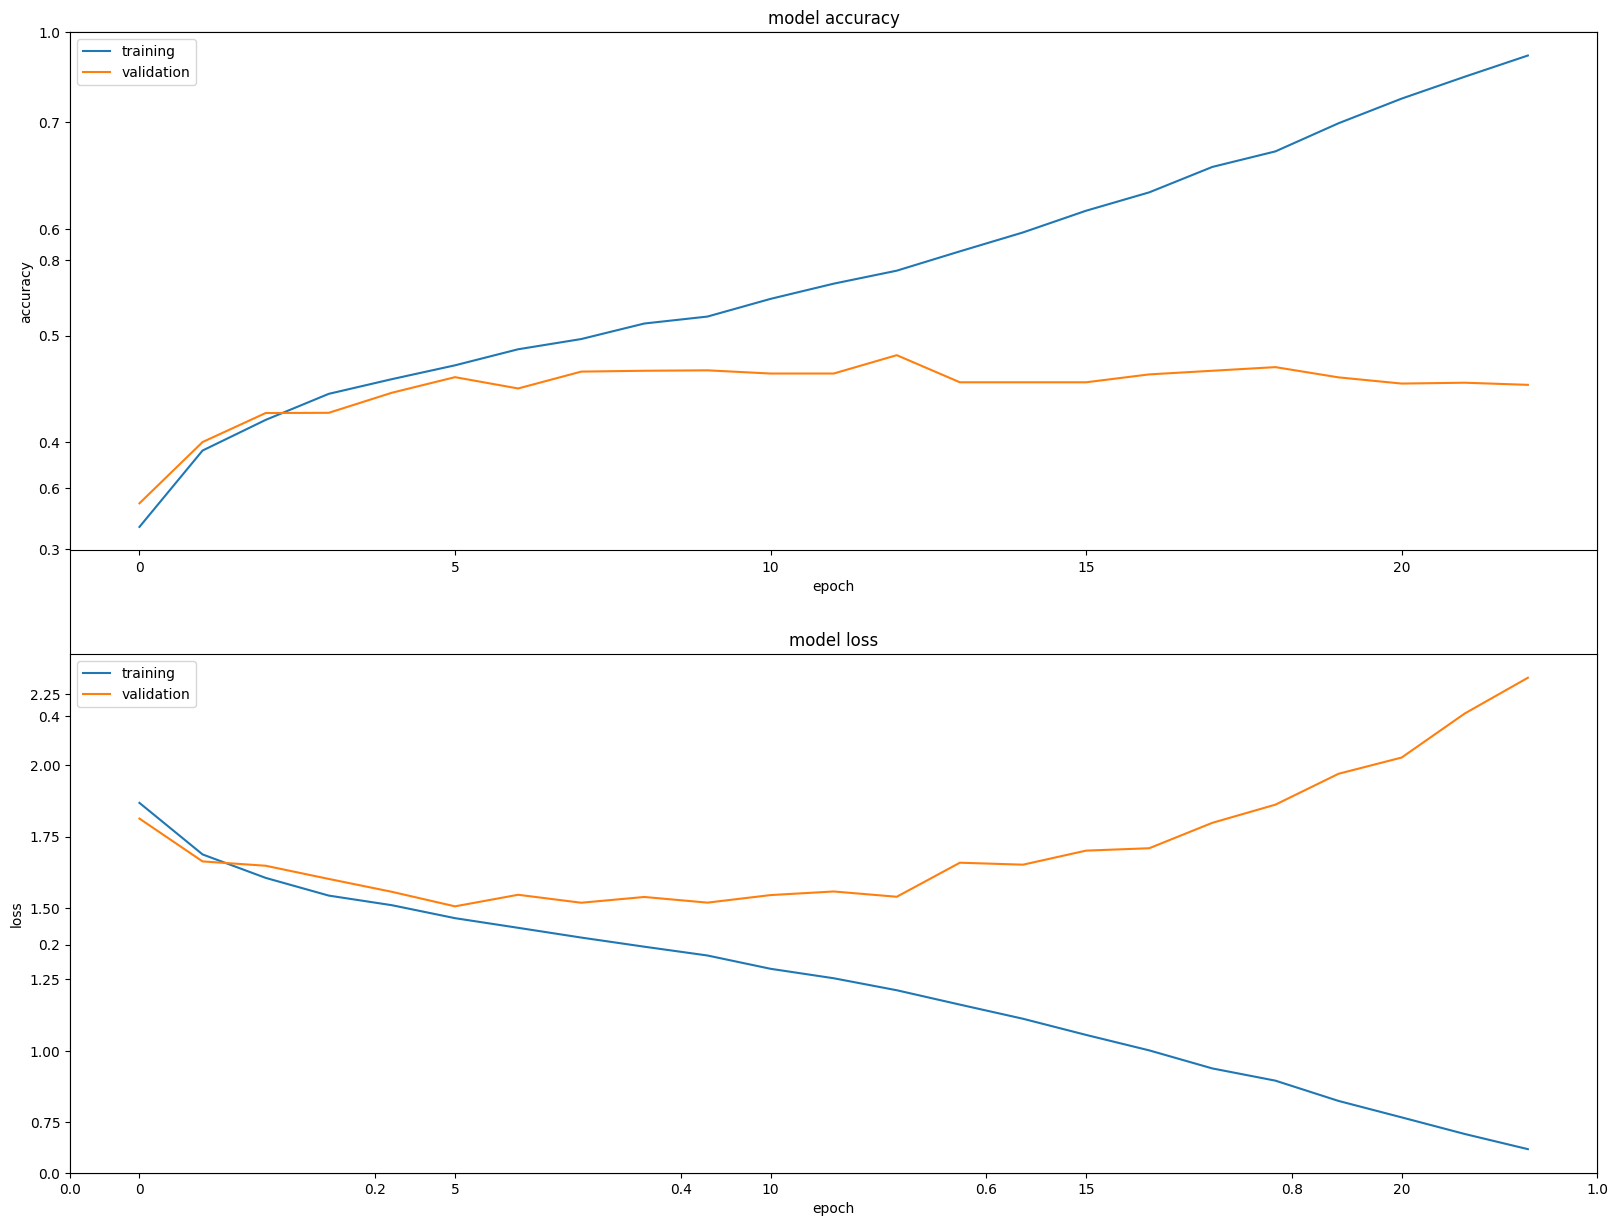

In [45]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_02.history['accuracy'], history_02.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_02.history['loss'], history_02.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [46]:
pred02_cm=np.argmax(pred02, axis=1)
print_validation_report(y_test, pred02_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.51      0.53      1000
           1       0.64      0.52      0.57      1000
           2       0.39      0.17      0.24      1000
           3       0.34      0.38      0.36      1000
           4       0.37      0.44      0.40      1000
           5       0.43      0.28      0.34      1000
           6       0.46      0.62      0.53      1000
           7       0.51      0.56      0.53      1000
           8       0.52      0.69      0.60      1000
           9       0.51      0.57      0.54      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000

Accuracy Score: 0.4742
Root Mean Square Error: 3.16234090508914


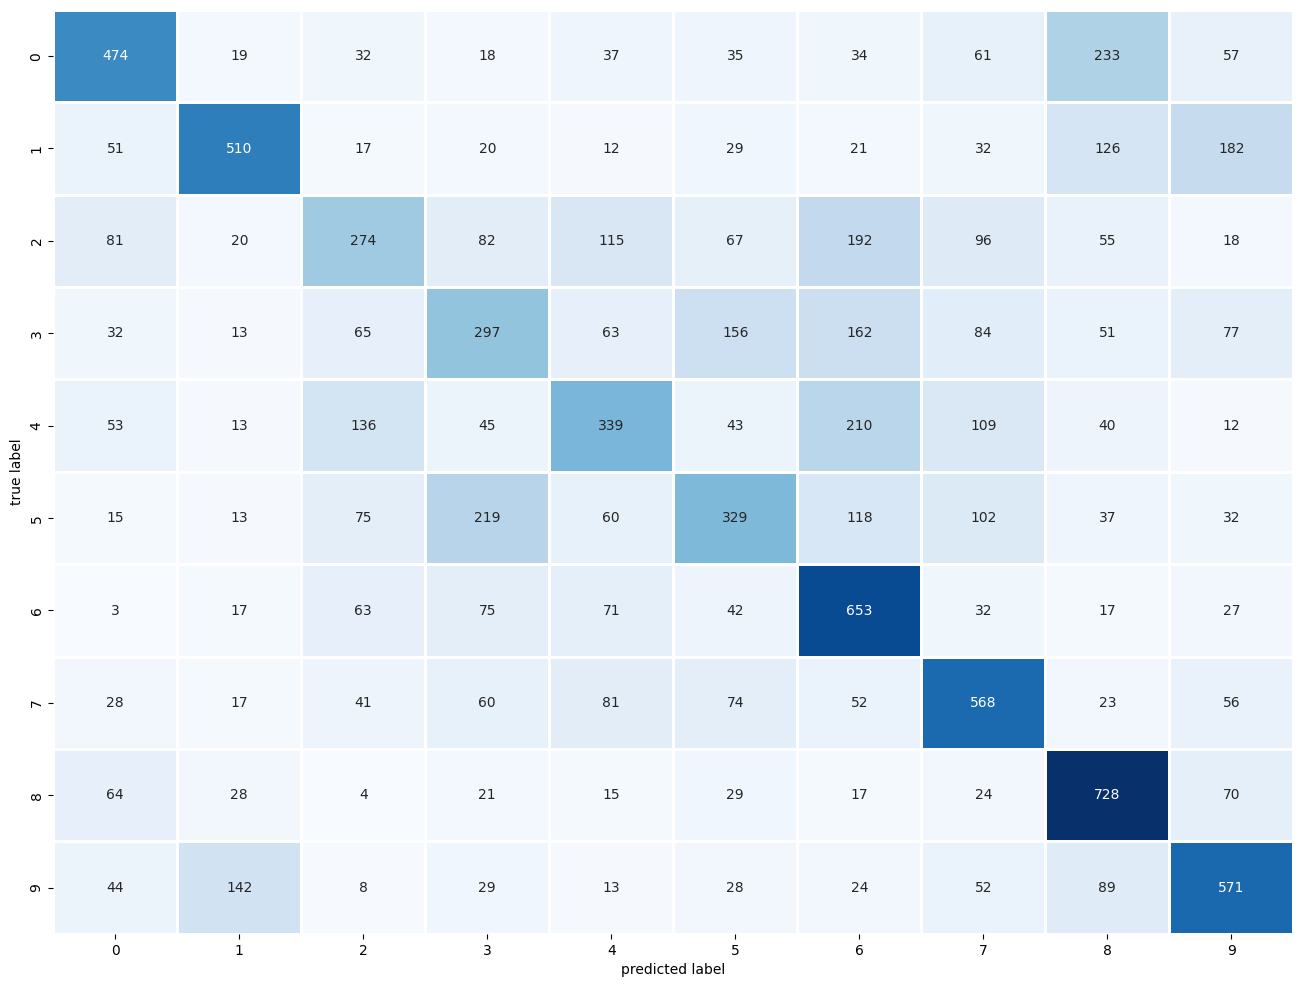

In [47]:
plot_confusion_matrix(y_test,pred01_cm)

In [48]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred02[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [49]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_02.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_02 = tf.keras.models.Model(inputs=model_02.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_02 = activation_model_02.predict(x_valid_norm[:3250])
activations_02 = activation_model_02.predict(x_valid_norm[:2000])
dense_layer_activations_02 = activations_02[-3]
output_layer_activations_02 = activations_02[-1]

63/63 [==============================] - 0s 917us/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [50]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_02 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_02 = tsne_02.fit_transform(dense_layer_activations_02)

# Scaling
tsne_results_02 = (tsne_results_02 - tsne_results_02.min()) / (tsne_results_02.max() - tsne_results_02.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.543442
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.850433
[t-SNE] KL divergence after 300 iterations: 2.353606


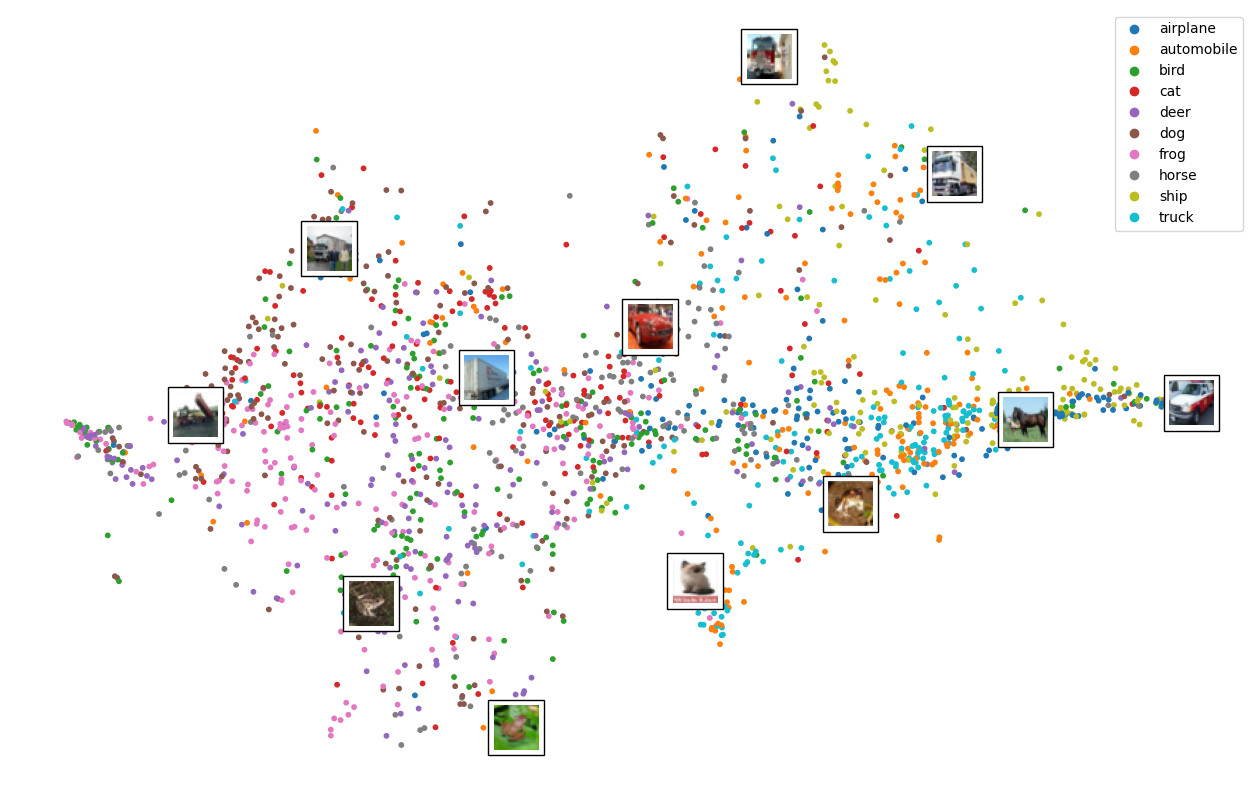

In [51]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_02[:,0],tsne_results_02[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_02[:,0],tsne_results_02[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_02):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 3**

- CNN with 2 layers/max pooling layers
- 1 full-connected layer
- no regularization

##### Build CNN Model

In [52]:
k.clear_session()
model_03 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment3"] = {}
results["Experiment3"]["Architecture"] = "• CNN with 2 layers/max pooling layers\n • 1 full-connected layer\n • no regularization"

In [53]:
model_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)               3

In [54]:
keras.utils.plot_model(model_03, "CIFAR10_EXP_03.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [55]:
model_03.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [56]:
# Start time
start_time = time.time()

history_03 = model_03.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_03_2CNN_2DNN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment3"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 5s 5ms/step - loss: 1.4488 - accuracy: 0.4804 - val_loss: 1.3456 - val_accuracy: 0.5360
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.0759 - accuracy: 0.6222 - val_loss: 1.0515 - val_accuracy: 0.6150
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 0.9241 - accuracy: 0.6772 - val_loss: 1.0442 - val_accuracy: 0.6276
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 0.8107 - accuracy: 0.7172 - val_loss: 0.9475 - val_accuracy: 0.6708
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 0.7048 - accuracy: 0.7544 - val_loss: 0.9167 - val_accuracy: 0.6832
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6097 - accuracy: 0.7870 - val_loss: 0.8989 - val_accuracy: 0.6956
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 0.5161 - accuracy: 0.8210 - val_loss: 0.9226 - val_accuracy: 0.7056

In [57]:
train_loss = history_03.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_03.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_03.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_03.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")


model_03 = tf.keras.models.load_model("A2_Exp_03_2CNN_2DNN.h5")
test_loss, test_accuracy = model_03.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment3"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment3"]["Test Loss"] = round(test_loss,3)
results["Experiment3"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment3"]["Train Loss"] = round(train_loss,3)
results["Experiment3"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment3"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.085, Training Accuracy: 0.970
Validation Loss: 2.025, Validation Accuracy: 0.685
Test Loss: 0.865, Test Accuracy: 0.713


In [58]:
pred03 = model_03.predict(x_test_norm)
print('shape of preds: ', pred03.shape)
history_03_dict = history_03.history
history_03_df=pd.DataFrame(history_03_dict)
history_03_df.tail().round(3)

313/313 [==============================] - 0s 952us/step
shape of preds:  (10000, 10)


loss  accuracy  val_loss  val_accuracy
14  0.108     0.962     1.779         0.693
15  0.089     0.969     1.792         0.691
16  0.086     0.970     1.870         0.691
17  0.074     0.974     1.982         0.686
18  0.085     0.970     2.025         0.685

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

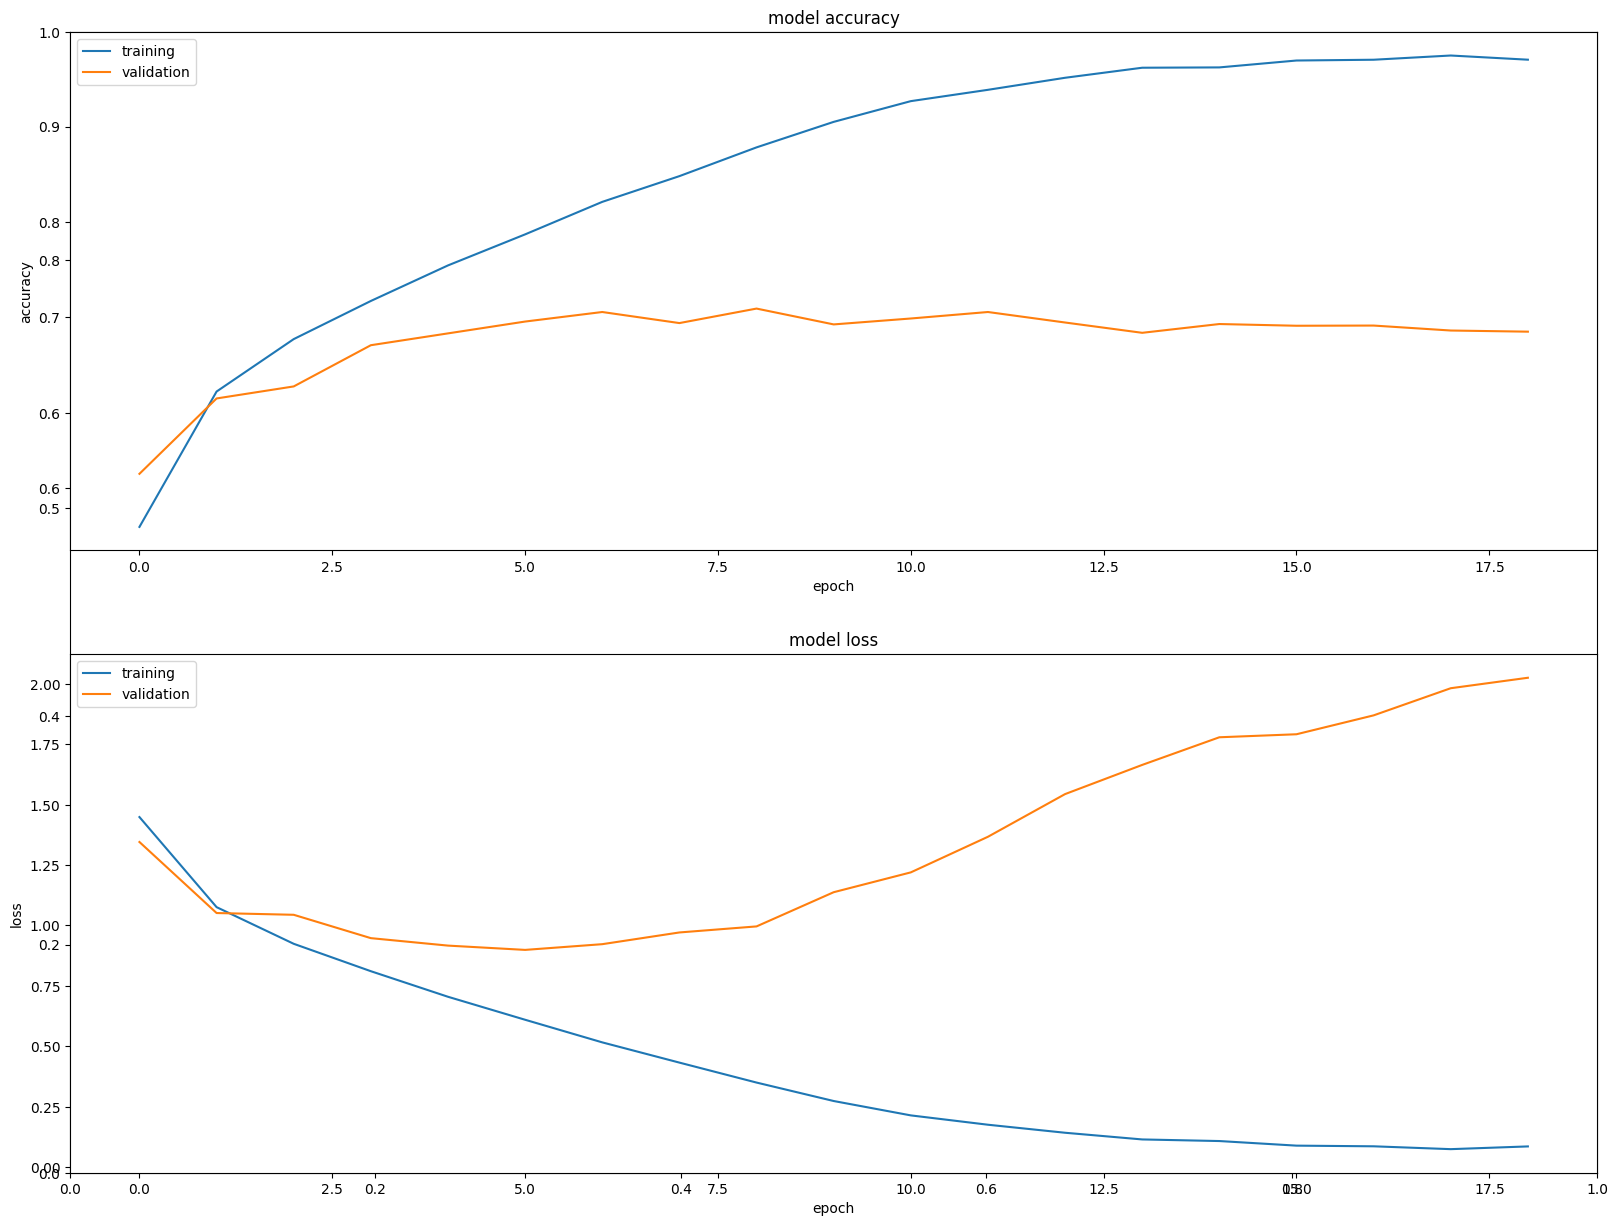

In [59]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_03.history['accuracy'], history_03.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_03.history['loss'], history_03.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [60]:
pred03_cm=np.argmax(pred03, axis=1)
print_validation_report(y_test, pred03_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      1000
           1       0.77      0.87      0.82      1000
           2       0.64      0.56      0.60      1000
           3       0.56      0.54      0.55      1000
           4       0.65      0.67      0.66      1000
           5       0.63      0.58      0.61      1000
           6       0.66      0.88      0.75      1000
           7       0.81      0.70      0.75      1000
           8       0.85      0.80      0.82      1000
           9       0.83      0.75      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

Accuracy Score: 0.7128
Root Mean Square Error: 2.2347930552961723


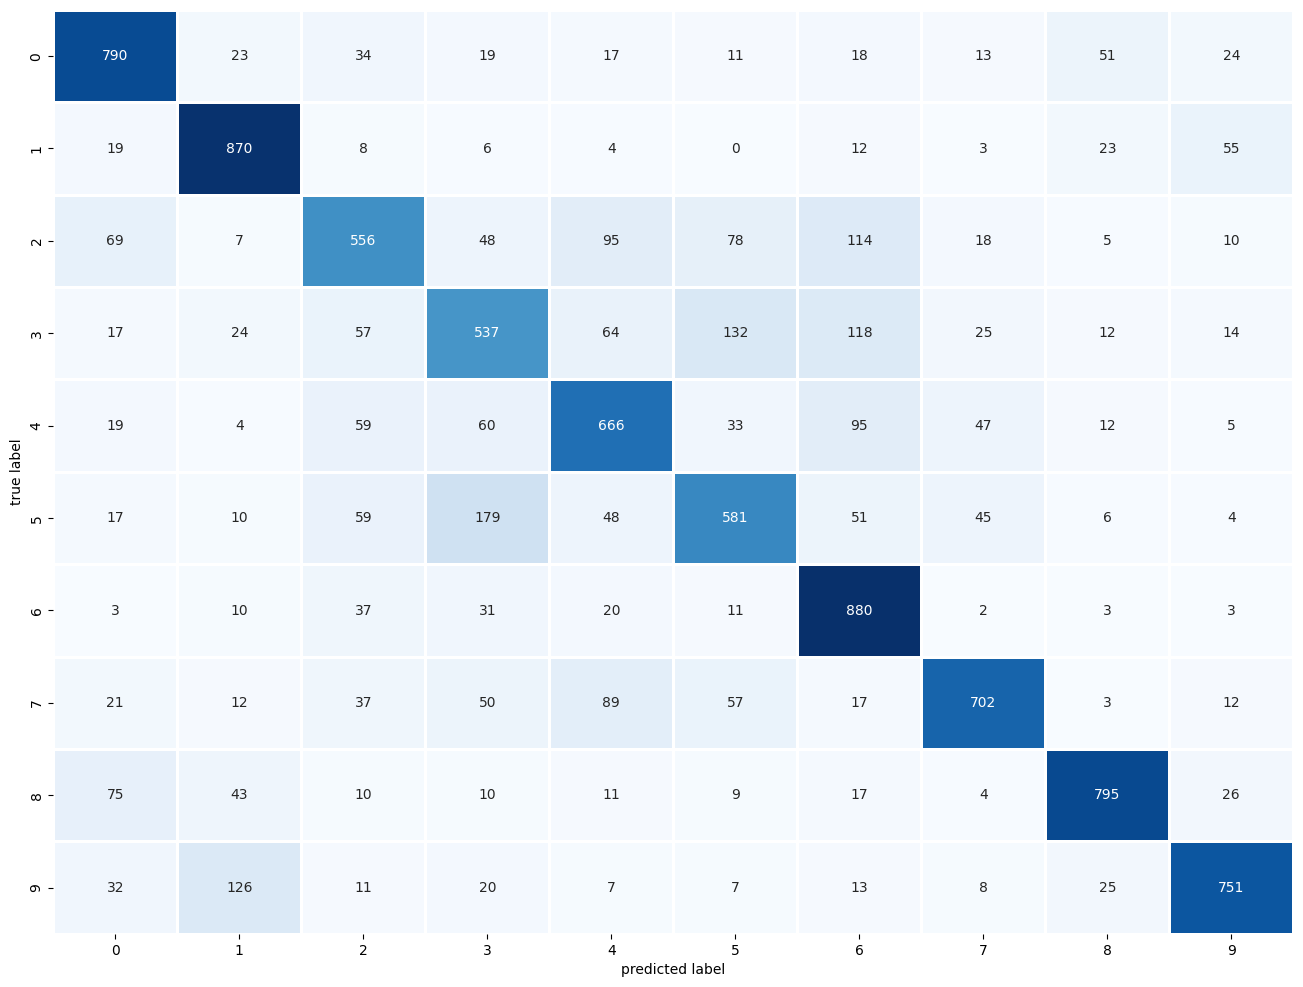

In [61]:
plot_confusion_matrix(y_test,pred03_cm)

In [62]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred03[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [63]:
layer_names = []
for layer in model_03.layers:
    layer_names.append(layer.name)

print(layer_names)

# Extracts the outputs of the top 8 layers:
layer_outputs_03 = [layer.output for layer in model_03.layers[:7]]
# Creates a model that will return these outputs, given the model input:
activation_model_03 = tf.keras.models.Model(inputs=model_03.input, outputs=layer_outputs_03)

# Get activation values for the last dense layer
# activations_03 = activation_model_03.predict(x_valid_norm[:3250])
activations_03 = activation_model_03.predict(x_valid_norm[:1000])
dense_layer_activations_03 = activations_03[-3]
output_layer_activations_03 = activations_03[-1]

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'flatten', 'dense', 'dense_1']
32/32 [==============================] - 0s 2ms/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [64]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_03 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_03 = tsne_03.fit_transform(dense_layer_activations_03)

# Scaling
tsne_results_03 = (tsne_results_03 - tsne_results_03.min()) / (tsne_results_03.max() - tsne_results_03.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.503065
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.902954
[t-SNE] KL divergence after 300 iterations: 1.957590


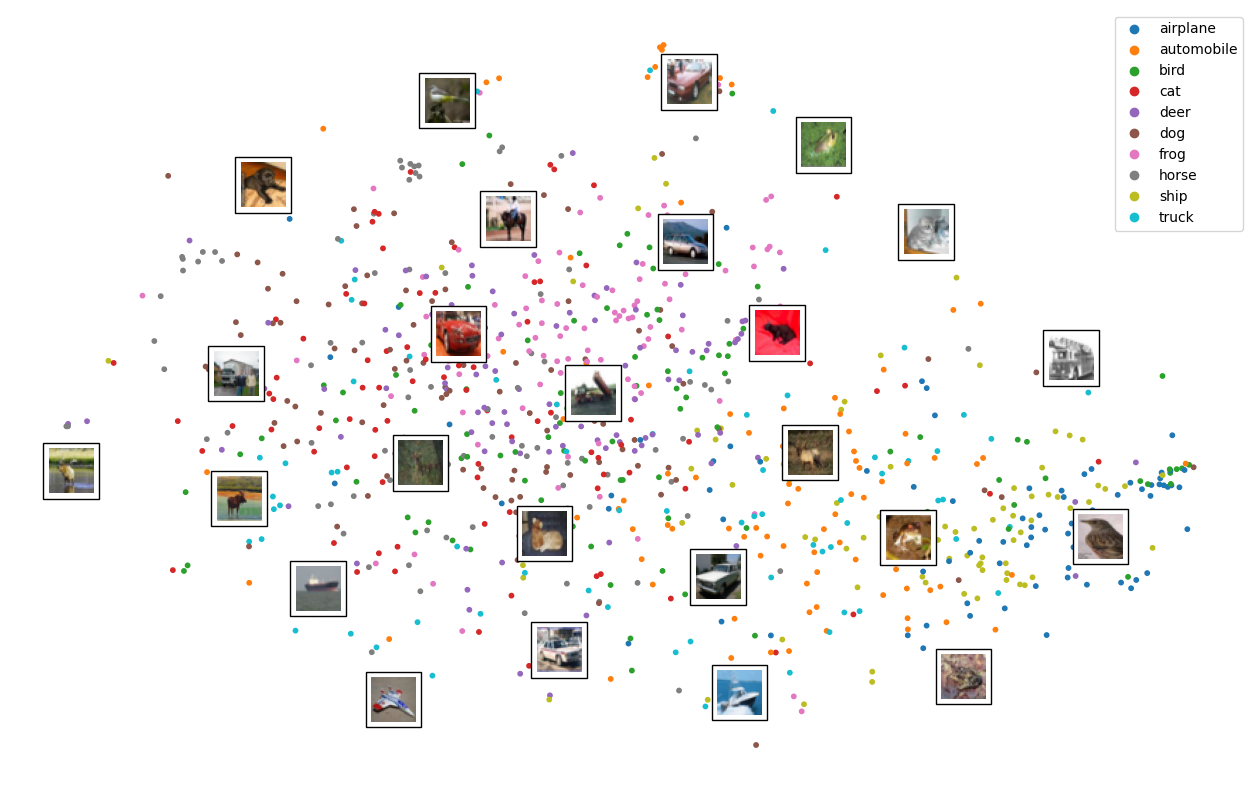

In [65]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_03[:,0],tsne_results_03[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_03[:,0],tsne_results_03[:,1], c=y_valid_split[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_03):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Result2:
Take Experiment 3 – Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

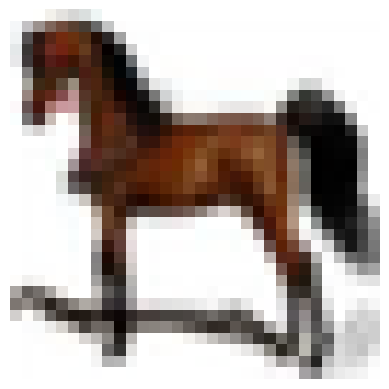

In [66]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [67]:
activations_cnn_03 = activation_model_03.predict(img_tensor)
len(activations_cnn_03)

1/1 [==============================] - 0s 67ms/step


7

In [68]:
layer_names = []
for layer in model_03.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

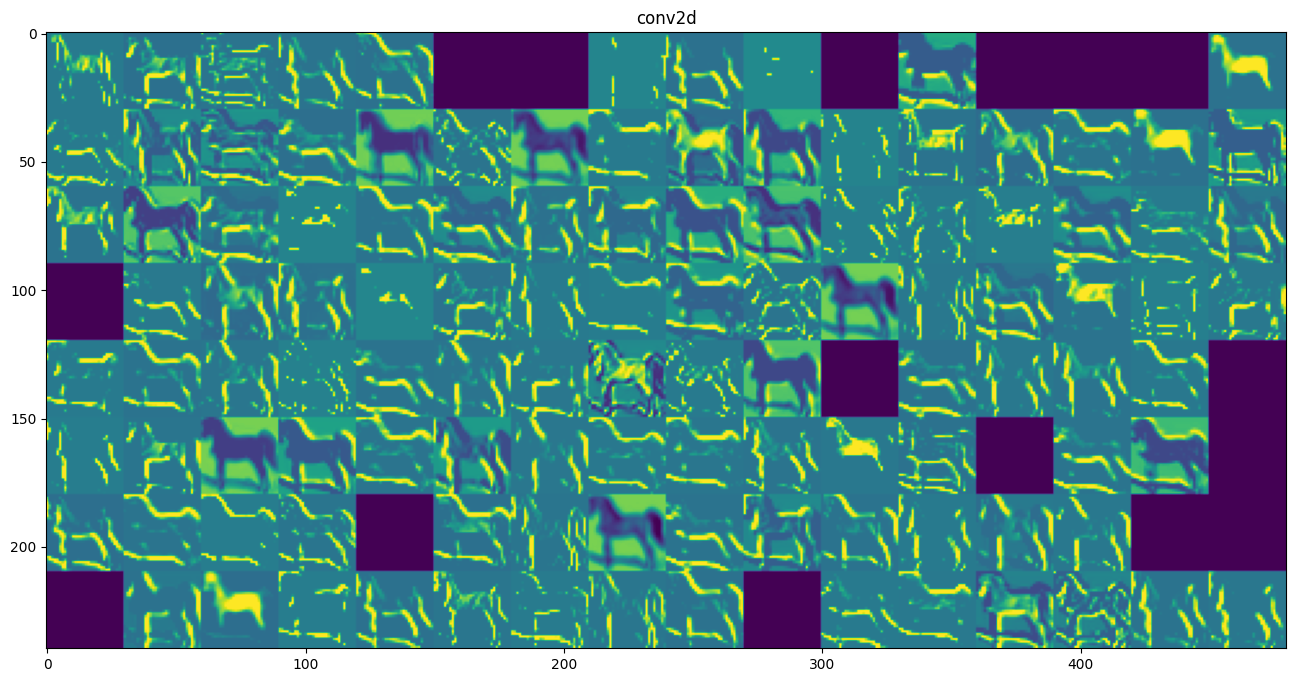

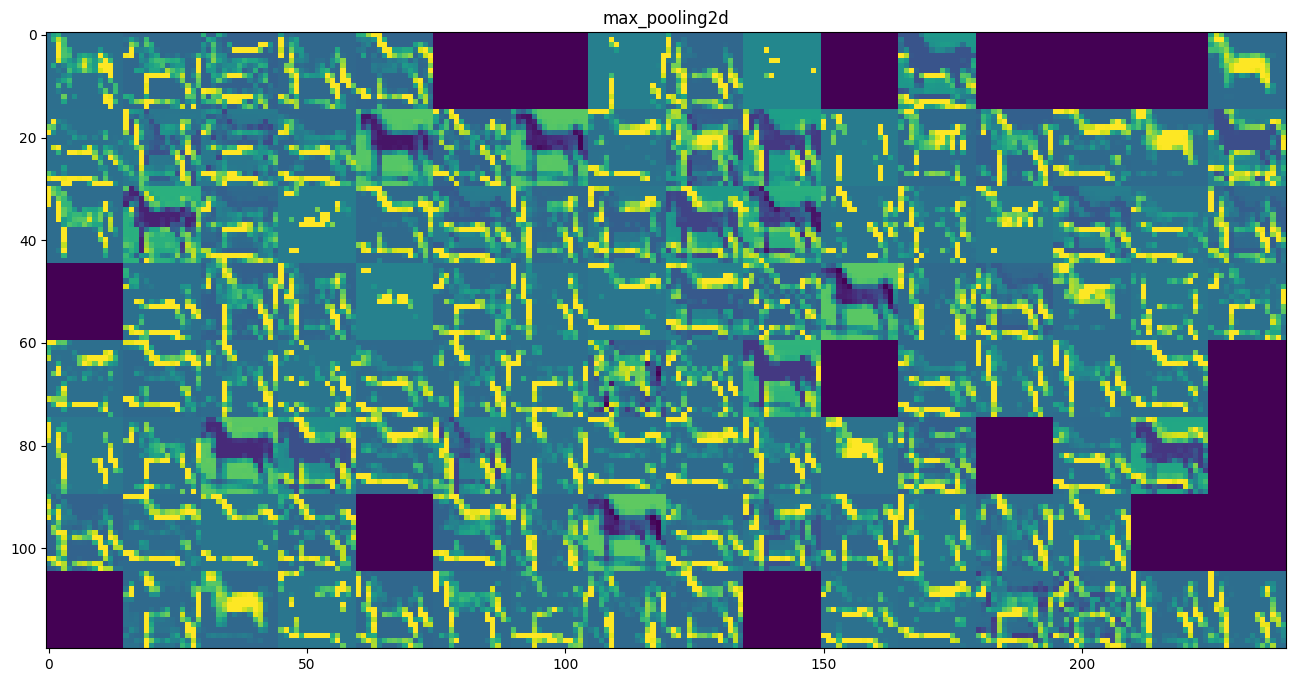

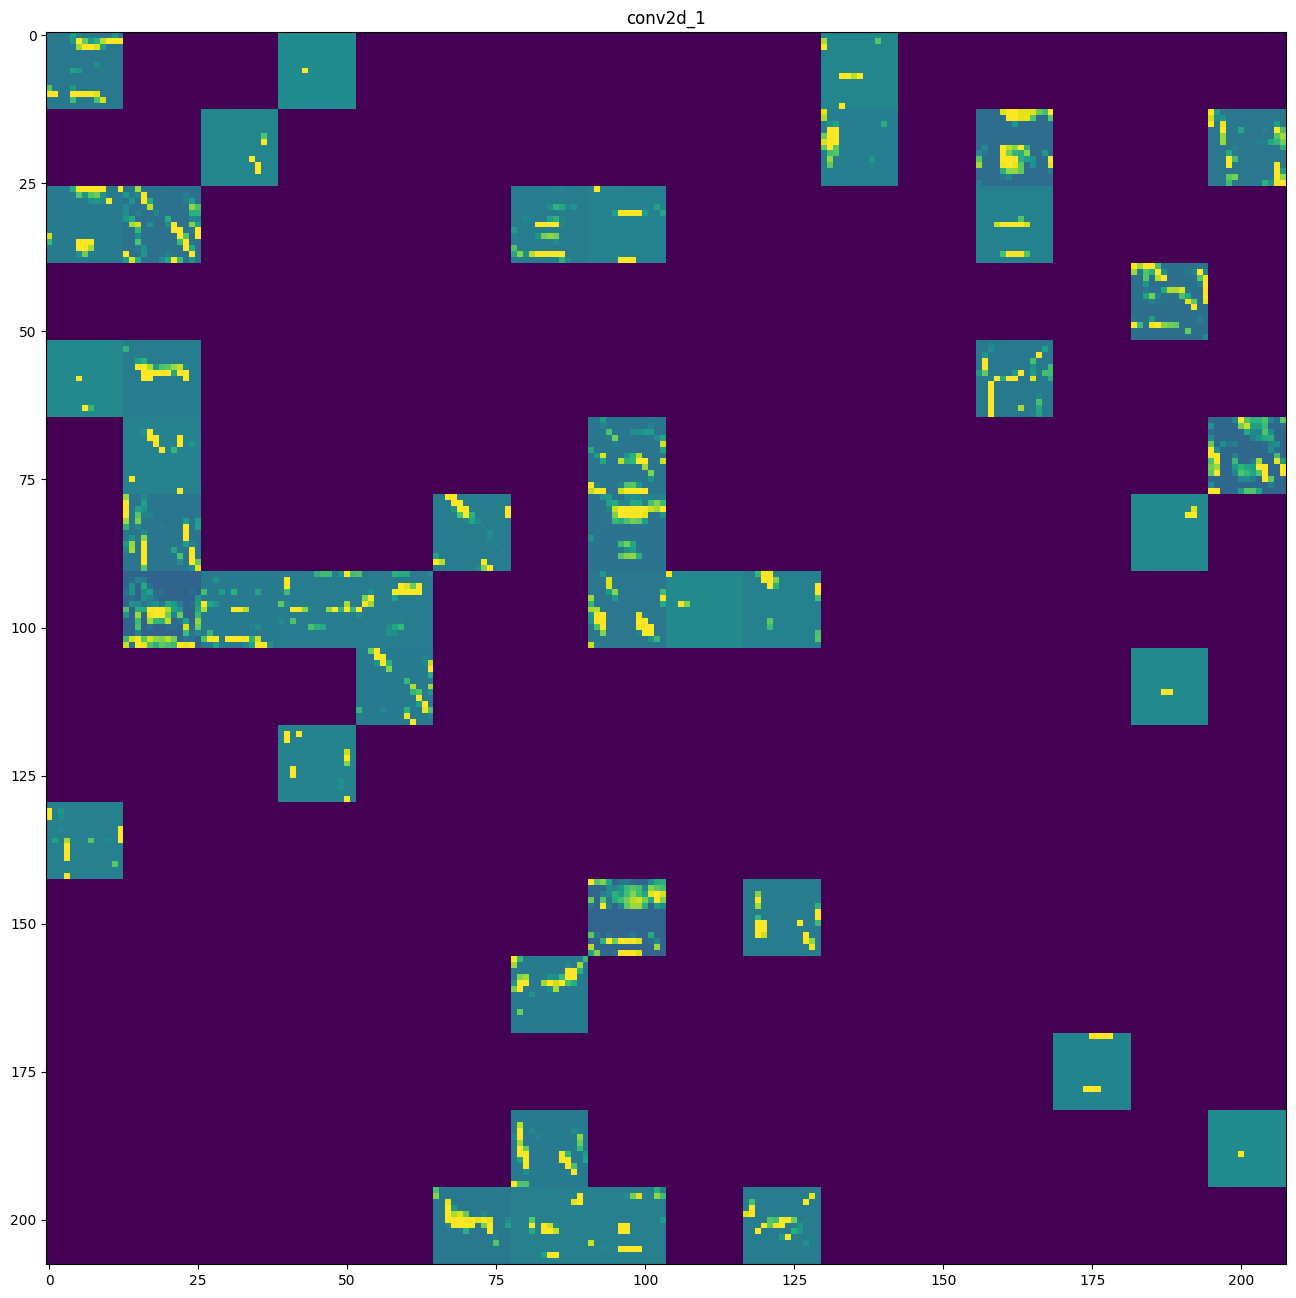

In [69]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_03.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_cnn_03):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();

## **Experiment 4**

- CNN with 3 layers/max pooling layers
- 1 fully-connected layer
- no regularization

##### Build CNN Model

In [70]:
k.clear_session()
model_04 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment4"] = {}
results["Experiment4"]["Architecture"] = "• CNN with 3 layers/max pooling layers\n • 1 full-connected layer\n • no regularization"

In [71]:
model_04.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 512)         0

In [72]:
keras.utils.plot_model(model_04, "CIFAR10_EXP_04.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [73]:
model_04.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [74]:
# Start time
start_time = time.time()

history_04 = model_04.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_04_3CNN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment4"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 5s 5ms/step - loss: 1.4767 - accuracy: 0.4625 - val_loss: 1.2243 - val_accuracy: 0.5536
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.0333 - accuracy: 0.6361 - val_loss: 0.9642 - val_accuracy: 0.6586
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 0.8341 - accuracy: 0.7078 - val_loss: 0.9427 - val_accuracy: 0.6744
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 0.6947 - accuracy: 0.7584 - val_loss: 0.8242 - val_accuracy: 0.7150
Epoch 5/200
704/704 [==============================] - 3s 4ms/step - loss: 0.5756 - accuracy: 0.7968 - val_loss: 0.8089 - val_accuracy: 0.7252
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 0.4726 - accuracy: 0.8346 - val_loss: 0.8448 - val_accuracy: 0.7164
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 0.3756 - accuracy: 0.8683 - val_loss: 0.8963 - val_accuracy: 0.7264

In [75]:
train_loss = history_04.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_04.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_04.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_04.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_04 = tf.keras.models.load_model("A2_Exp_04_3CNN.h5")
test_loss, test_accuracy = model_04.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment4"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment4"]["Test Loss"] = round(test_loss,3)
results["Experiment4"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment4"]["Train Loss"] = round(train_loss,3)
results["Experiment4"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment4"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.048, Training Accuracy: 0.985
Validation Loss: 2.322, Validation Accuracy: 0.723
Test Loss: 0.794, Test Accuracy: 0.736


In [76]:
pred04 = model_04.predict(x_test_norm)
print('shape of preds: ', pred04.shape)

history_04_dict = history_04.history
history_04_df=pd.DataFrame(history_04_dict)
history_04_df.tail().round(3)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


loss  accuracy  val_loss  val_accuracy
33  0.051     0.984     2.155         0.728
34  0.050     0.984     2.241         0.718
35  0.051     0.984     2.304         0.720
36  0.057     0.981     2.124         0.728
37  0.048     0.985     2.322         0.723

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

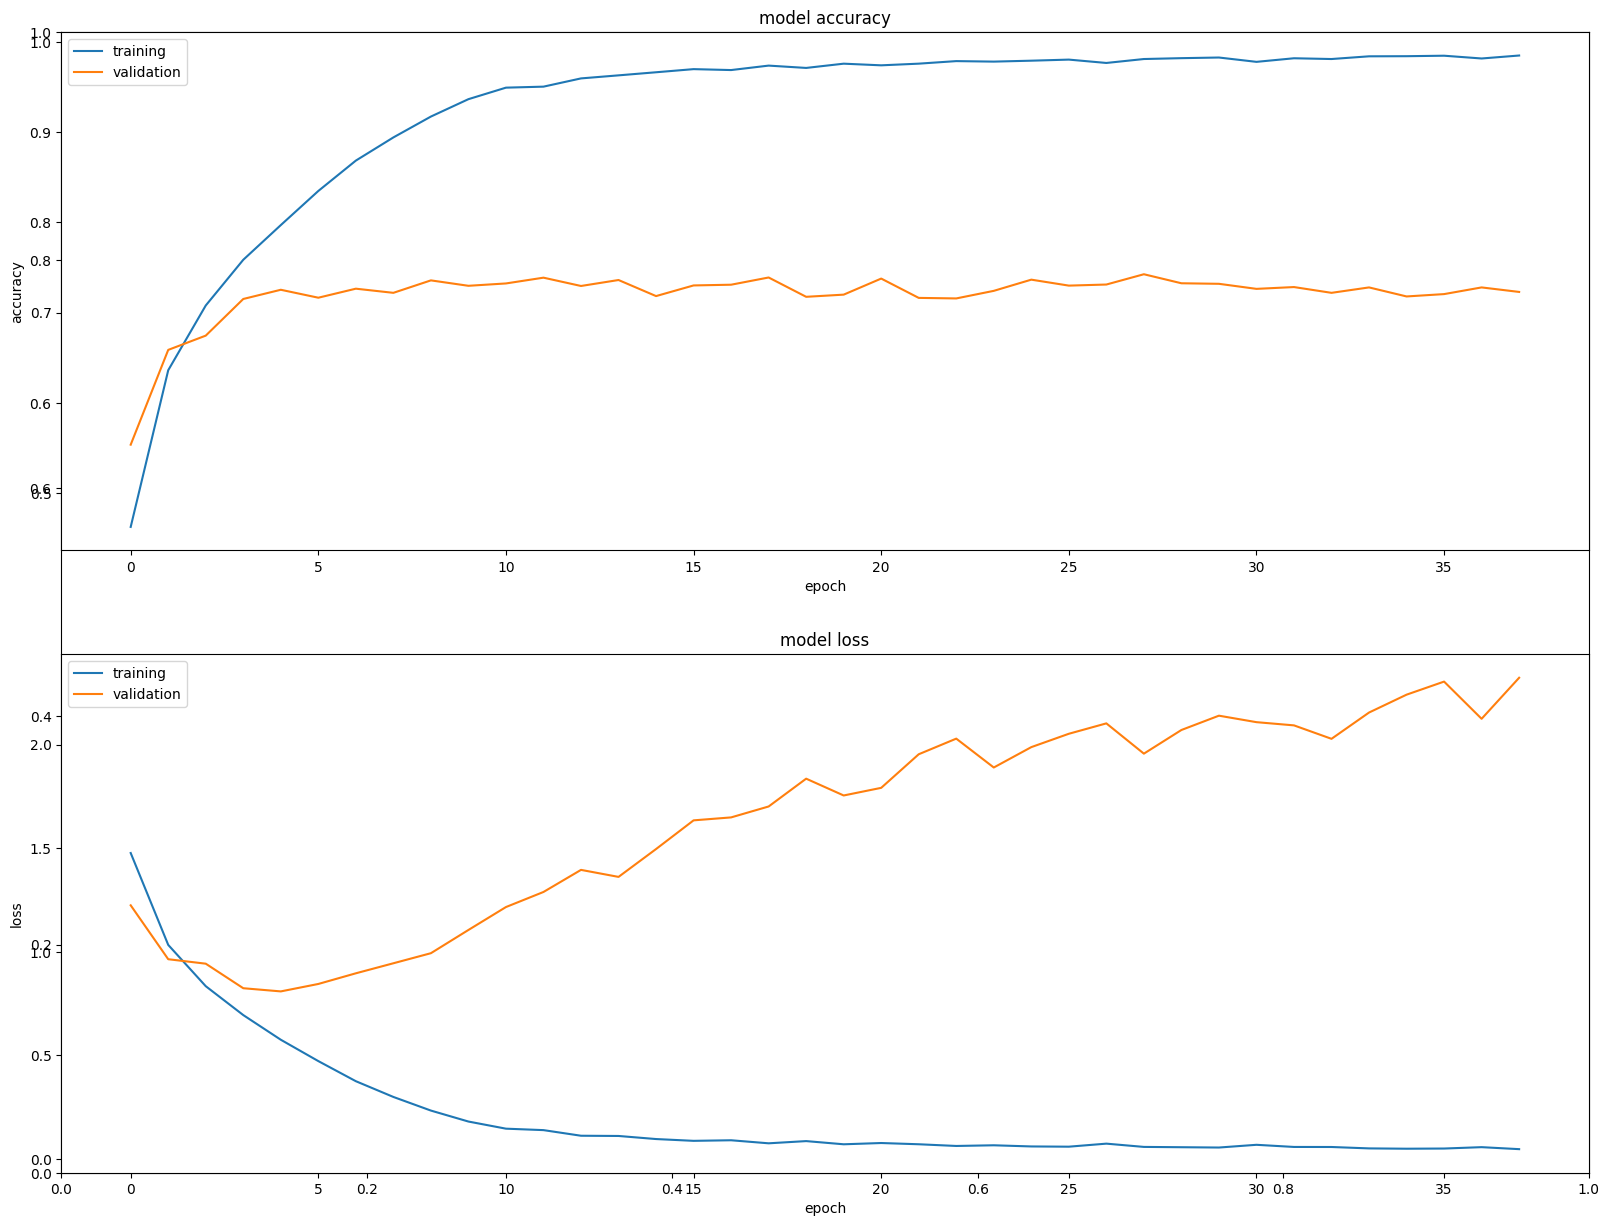

In [77]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_04.history['accuracy'], history_04.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_04.history['loss'], history_04.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [78]:
pred04_cm=np.argmax(pred04, axis=1)
print_validation_report(y_test, pred04_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1000
           1       0.91      0.82      0.86      1000
           2       0.64      0.65      0.65      1000
           3       0.67      0.44      0.53      1000
           4       0.64      0.76      0.69      1000
           5       0.66      0.66      0.66      1000
           6       0.79      0.79      0.79      1000
           7       0.80      0.75      0.77      1000
           8       0.72      0.91      0.80      1000
           9       0.80      0.82      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.73     10000
weighted avg       0.74      0.74      0.73     10000

Accuracy Score: 0.736
Root Mean Square Error: 2.1444113411377024


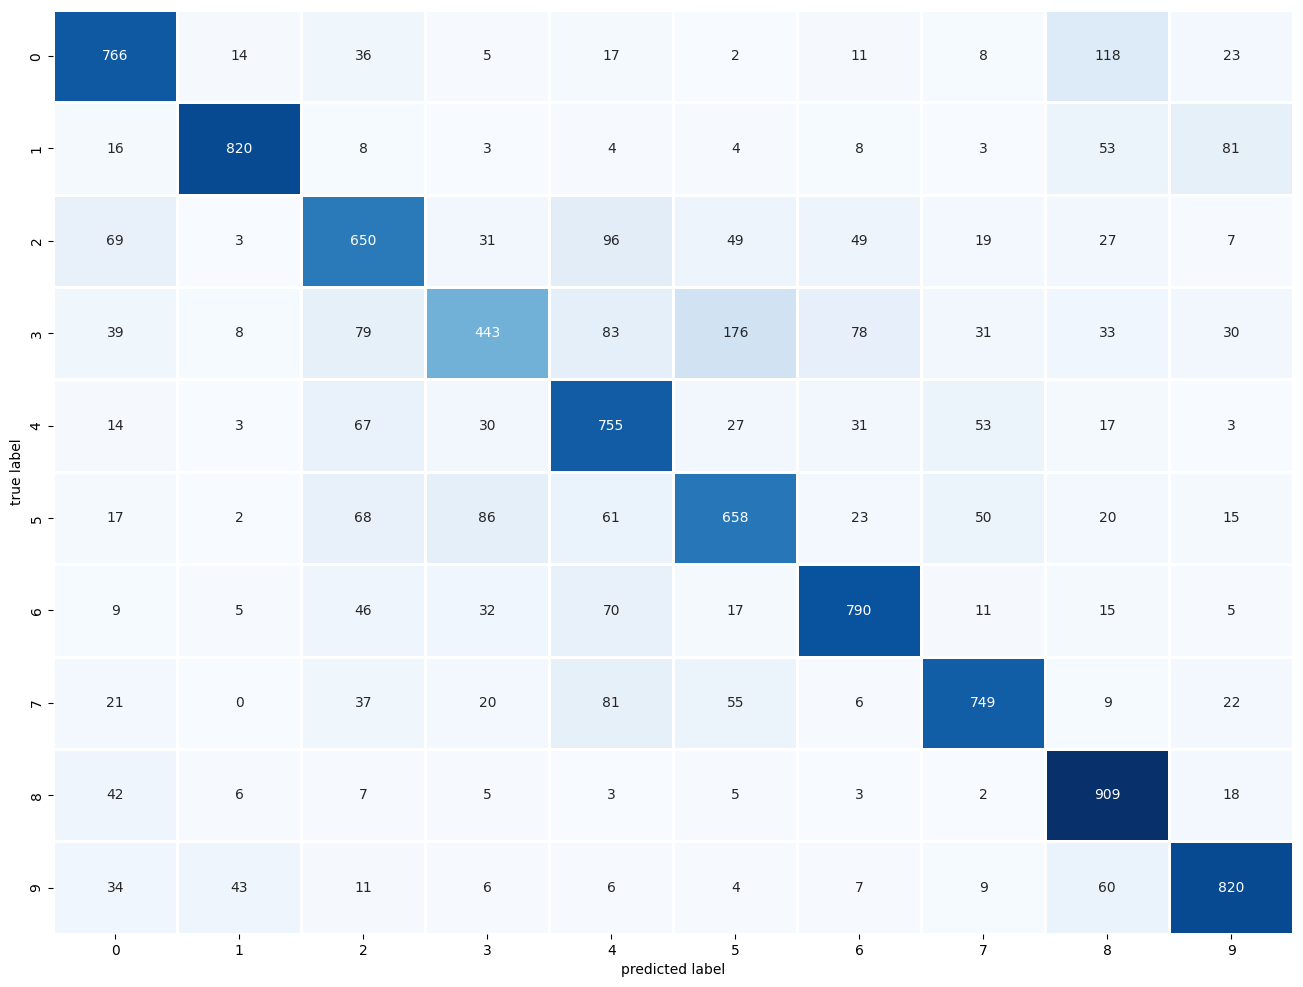

In [79]:
plot_confusion_matrix(y_test,pred04_cm)

In [80]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred04[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [81]:
layer_names = []
for layer in model_04.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1']

In [82]:
# Extracts the outputs of the top 11 layers:
layer_outputs_04 = [layer.output for layer in model_04.layers[:13]]
# Creates a model that will return these outputs, given the model input:
activation_model_04 = tf.keras.models.Model(inputs=model_04.input, outputs=layer_outputs_04)

# Get activation values for the last dense layer
# activations_04 = activation_model_04.predict(x_valid_norm[:3250])
activations_04 = activation_model_04.predict(x_valid_norm[:1000])
dense_layer_activations_04 = activations_04[-3]
output_layer_activations_04 = activations_04[-1]

32/32 [==============================] - 0s 1ms/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [83]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_04 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_04 = tsne_04.fit_transform(dense_layer_activations_04)

# Scaling
tsne_results_04 = (tsne_results_04 - tsne_results_04.min()) / (tsne_results_04.max() - tsne_results_04.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.816506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.036034
[t-SNE] KL divergence after 300 iterations: 1.867316


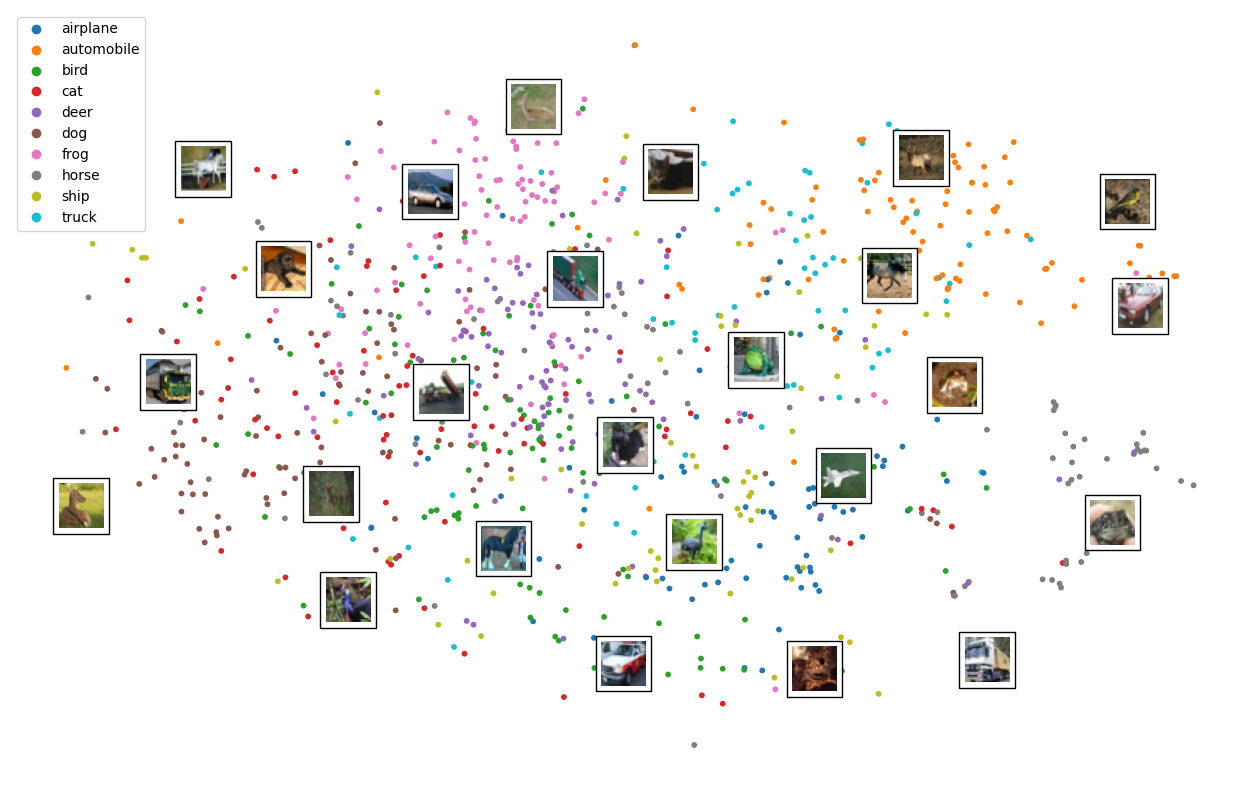

In [84]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_04[:,0],tsne_results_04[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_04[:,0],tsne_results_04[:,1], c=y_valid_split[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_04):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 5**

- DNN with 2 layers (384, 768)
- Batch Normalization
- L2 Regularization(0.001)

##### Build CNN Model

In [85]:
k.clear_session()
model_05 = Sequential([
   Flatten(input_shape=x_train_norm.shape[1:]),
   Dense(units=384,activation=tf.nn.relu),
#   Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
   BatchNormalization(),
#   Dropout(0.3),
   Dense(units=768,activation=tf.nn.relu),
#   Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
   BatchNormalization(),
#   Dropout(0.3),
   Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment5"] = {}
results["Experiment5"]["Architecture"] = "• DNN with 2 layers (384, 768)\n • Batch Normalization\n • L2 Regularization(0.001)"

In [86]:
model_05.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 batch_normalization (Batch  (None, 384)               1536      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 batch_normalization_1 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                7

In [87]:
keras.utils.plot_model(model_05, "CIFAR10_EXP_05.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [88]:
model_05.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [89]:
# Start time
start_time = time.time()

history_05 = model_05.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_05_2DNN_BN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment5"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 4s 3ms/step - loss: 1.7934 - accuracy: 0.3757 - val_loss: 1.8845 - val_accuracy: 0.3346
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6300 - accuracy: 0.4255 - val_loss: 1.9138 - val_accuracy: 0.3520
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5344 - accuracy: 0.4576 - val_loss: 1.7508 - val_accuracy: 0.3996
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4796 - accuracy: 0.4782 - val_loss: 1.8204 - val_accuracy: 0.4072
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4278 - accuracy: 0.4950 - val_loss: 1.7341 - val_accuracy: 0.4230
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.3750 - accuracy: 0.5170 - val_loss: 1.7756 - val_accuracy: 0.4160
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.3320 - accuracy: 0.5323 - val_loss: 1.5763 - val_accuracy: 0.4724

In [90]:
train_loss = history_05.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_05.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_05.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_05.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_05 = tf.keras.models.load_model("A2_Exp_05_2DNN_BN.h5")
test_loss, test_accuracy = model_05.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment5"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment5"]["Test Loss"] = round(test_loss,3)
results["Experiment5"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment5"]["Train Loss"] = round(train_loss,3)
results["Experiment5"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment5"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.991, Training Accuracy: 0.650
Validation Loss: 1.637, Validation Accuracy: 0.477
Test Loss: 1.482, Test Accuracy: 0.490


In [91]:
pred05 = model_05.predict(x_test_norm)
print('shape of preds: ', pred05.shape)

313/313 [==============================] - 0s 938us/step
shape of preds:  (10000, 10)


In [92]:
history_05_dict = history_05.history
history_05_dict.keys()

history_05_df=pd.DataFrame(history_05_dict)
history_05_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
15  1.076     0.621     1.612         0.481
16  1.053     0.626     1.619         0.478
17  1.029     0.635     1.751         0.466
18  1.013     0.639     1.676         0.455
19  0.991     0.650     1.637         0.477

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

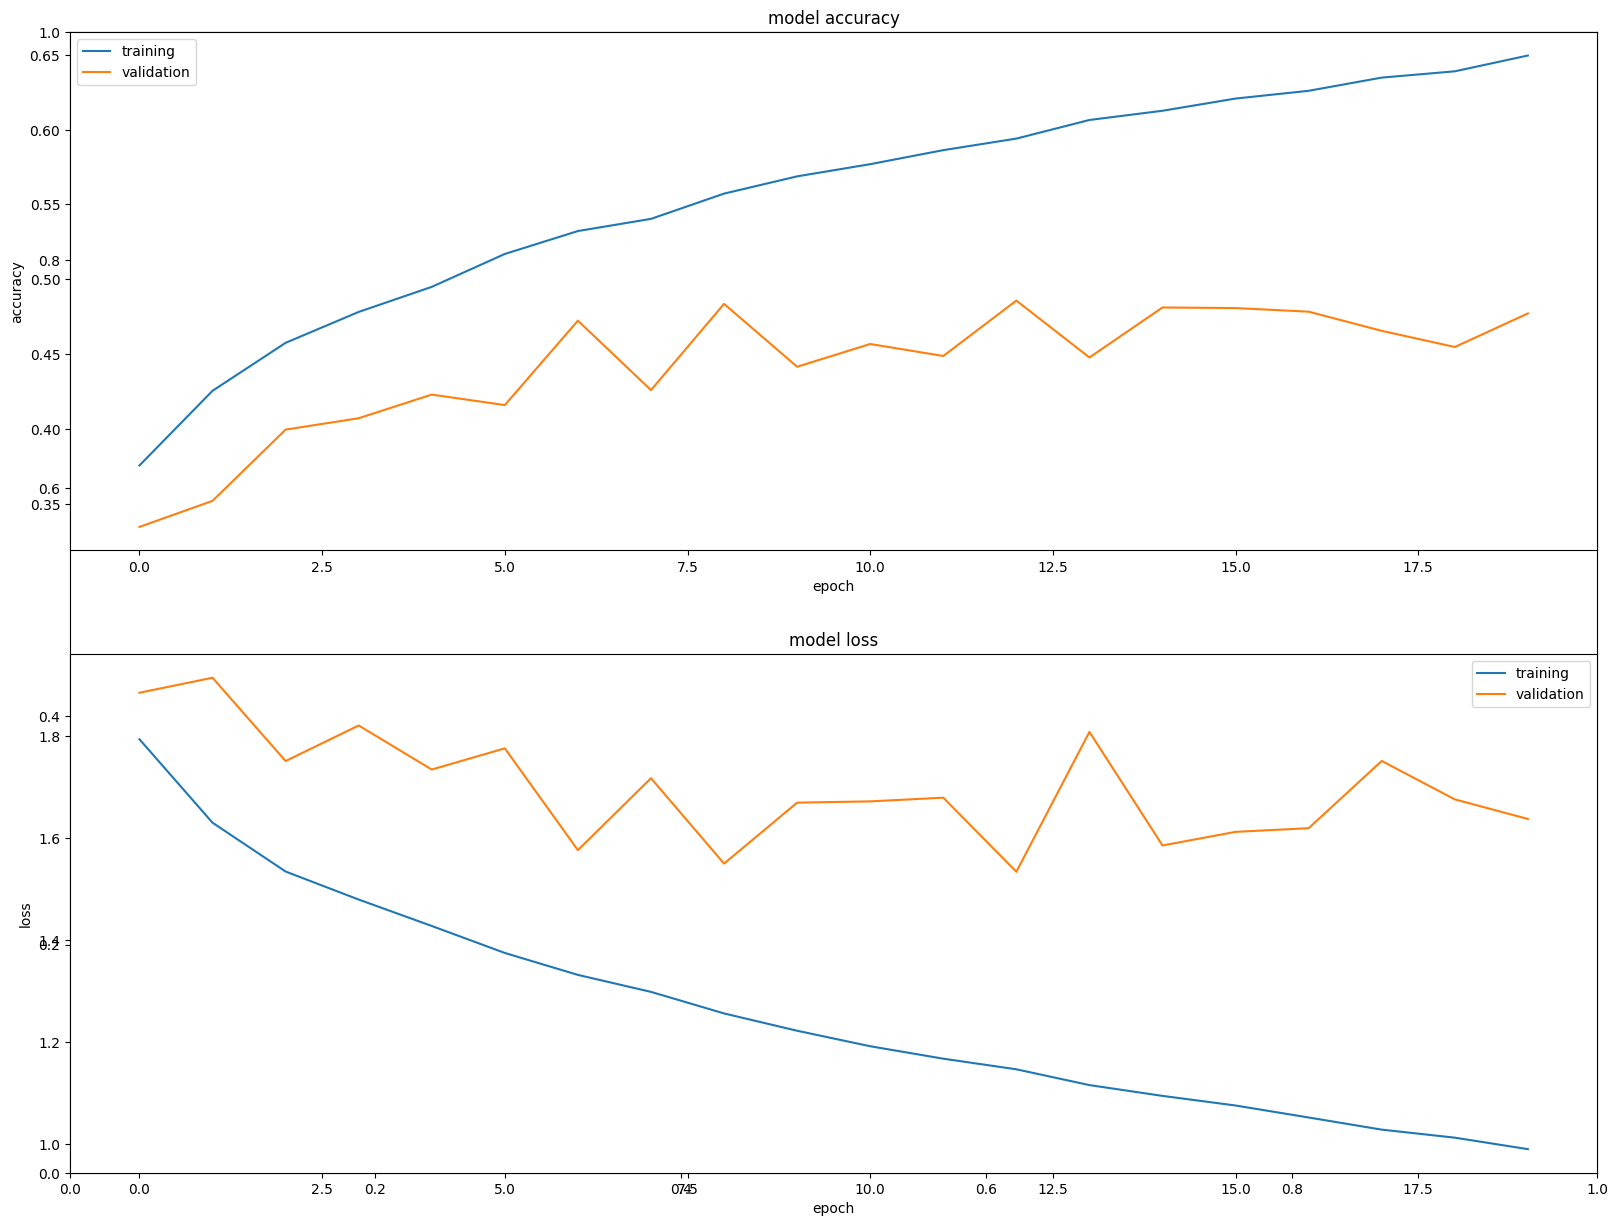

In [93]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_05.history['accuracy'], history_05.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_05.history['loss'], history_05.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [94]:
pred05_cm=np.argmax(pred05, axis=1)
print_validation_report(y_test, pred05_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.31      0.43      1000
           1       0.69      0.46      0.55      1000
           2       0.35      0.45      0.40      1000
           3       0.42      0.13      0.20      1000
           4       0.43      0.44      0.43      1000
           5       0.41      0.49      0.44      1000
           6       0.52      0.60      0.56      1000
           7       0.54      0.60      0.56      1000
           8       0.59      0.69      0.64      1000
           9       0.44      0.73      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.51      0.49      0.48     10000
weighted avg       0.51      0.49      0.48     10000

Accuracy Score: 0.4898
Root Mean Square Error: 3.205604467179318


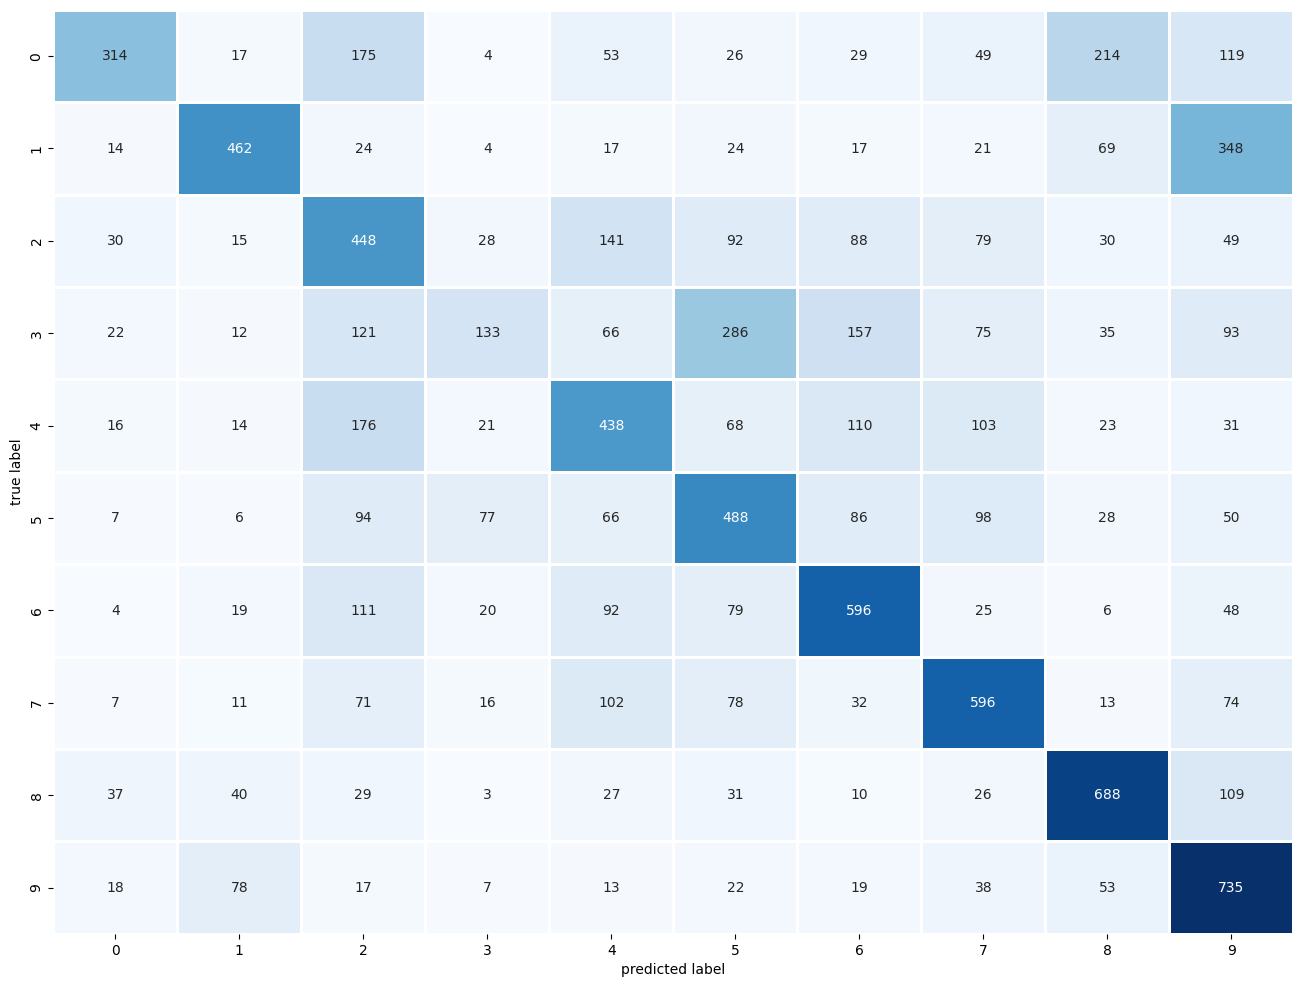

In [95]:
plot_confusion_matrix(y_test,pred05_cm)

In [96]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred05[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [97]:
layer_names = []
for layer in model_05.layers:
    layer_names.append(layer.name)

layer_names

['flatten',
 'dense',
 'batch_normalization',
 'dense_1',
 'batch_normalization_1',
 'dense_2']

In [98]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_05.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model_05 = tf.keras.models.Model(inputs=model_05.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_05 = activation_model_05.predict(x_valid_norm[:3250])
activations_05 = activation_model_05.predict(x_valid_norm[:1500])
dense_layer_activations_05 = activations_05[-3]
output_layer_activations_05 = activations_05[-1]

47/47 [==============================] - 0s 943us/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [99]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_05 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_05 = tsne_05.fit_transform(dense_layer_activations_05)

# Scaling
tsne_results_05 = (tsne_results_05 - tsne_results_05.min()) / (tsne_results_05.max() - tsne_results_05.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 4.815121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.247437
[t-SNE] KL divergence after 300 iterations: 1.694011


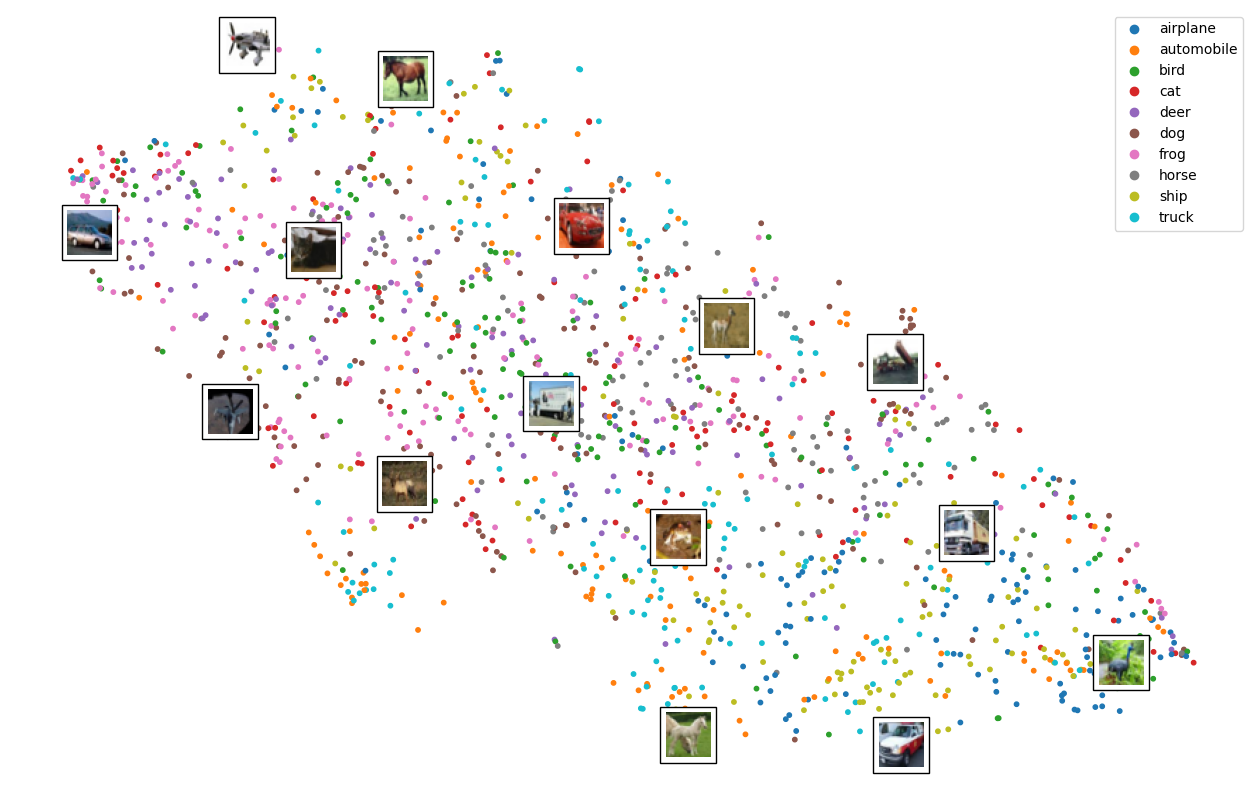

In [100]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results_05[:,0],tsne_results_05[:,1], c=y_valid_split[:1500], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_05):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 6**

- DNN with 3 layers
- Regularization: batch normalization

##### Build CNN Model

In [101]:
k.clear_session()
model_06 = Sequential([
  Flatten(input_shape=x_train_norm.shape[1:]),
  Dense(units=384,activation=tf.nn.relu),
  BatchNormalization(),
  Dense(units=768,activation=tf.nn.relu),
  BatchNormalization(),
  Dense(units=1536,activation=tf.nn.relu),
  BatchNormalization(),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment6"] = {}
results["Experiment6"]["Architecture"] = "• DNN with 3 layers\n • Regularization: batch normalization"

In [102]:
model_06.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 384)               1180032   
                                                                 
 batch_normalization (Batch  (None, 384)               1536      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 batch_normalization_1 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1536)              1

In [103]:
keras.utils.plot_model(model_06, "CIFAR10_EXP_06.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [104]:
model_06.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [105]:
# Start time
start_time = time.time()

history_06 = model_06.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_06_3DNN_BN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment6"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 4s 4ms/step - loss: 1.8833 - accuracy: 0.3563 - val_loss: 1.9355 - val_accuracy: 0.3538
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6770 - accuracy: 0.4168 - val_loss: 2.0260 - val_accuracy: 0.3426
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5890 - accuracy: 0.4464 - val_loss: 2.0122 - val_accuracy: 0.3434
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5105 - accuracy: 0.4751 - val_loss: 2.0802 - val_accuracy: 0.3500
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4396 - accuracy: 0.4984 - val_loss: 1.7454 - val_accuracy: 0.3938
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.3771 - accuracy: 0.5208 - val_loss: 1.5798 - val_accuracy: 0.4652
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.3153 - accuracy: 0.5418 - val_loss: 1.6387 - val_accuracy: 0.4338

In [106]:
train_loss = history_06.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_06.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_06.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_06.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_06 = tf.keras.models.load_model("A2_Exp_06_3DNN_BN.h5")
test_loss, test_accuracy = model_06.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment6"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment6"]["Test Loss"] = round(test_loss,3)
results["Experiment6"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment6"]["Train Loss"] = round(train_loss,3)
results["Experiment6"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment6"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.581, Training Accuracy: 0.792
Validation Loss: 2.413, Validation Accuracy: 0.478
Test Loss: 1.480, Test Accuracy: 0.483


In [107]:
pred06 = model_06.predict(x_test_norm)
print('shape of preds: ', pred06.shape)

313/313 [==============================] - 0s 960us/step
shape of preds:  (10000, 10)


In [108]:
history_06_dict = history_06.history
history_06_df=pd.DataFrame(history_06_dict)
history_06_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
18  0.742     0.733    37.450         0.448
19  0.695     0.750     4.853         0.474
20  0.653     0.766     2.316         0.462
21  0.625     0.773     2.446         0.471
22  0.581     0.792     2.413         0.478

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

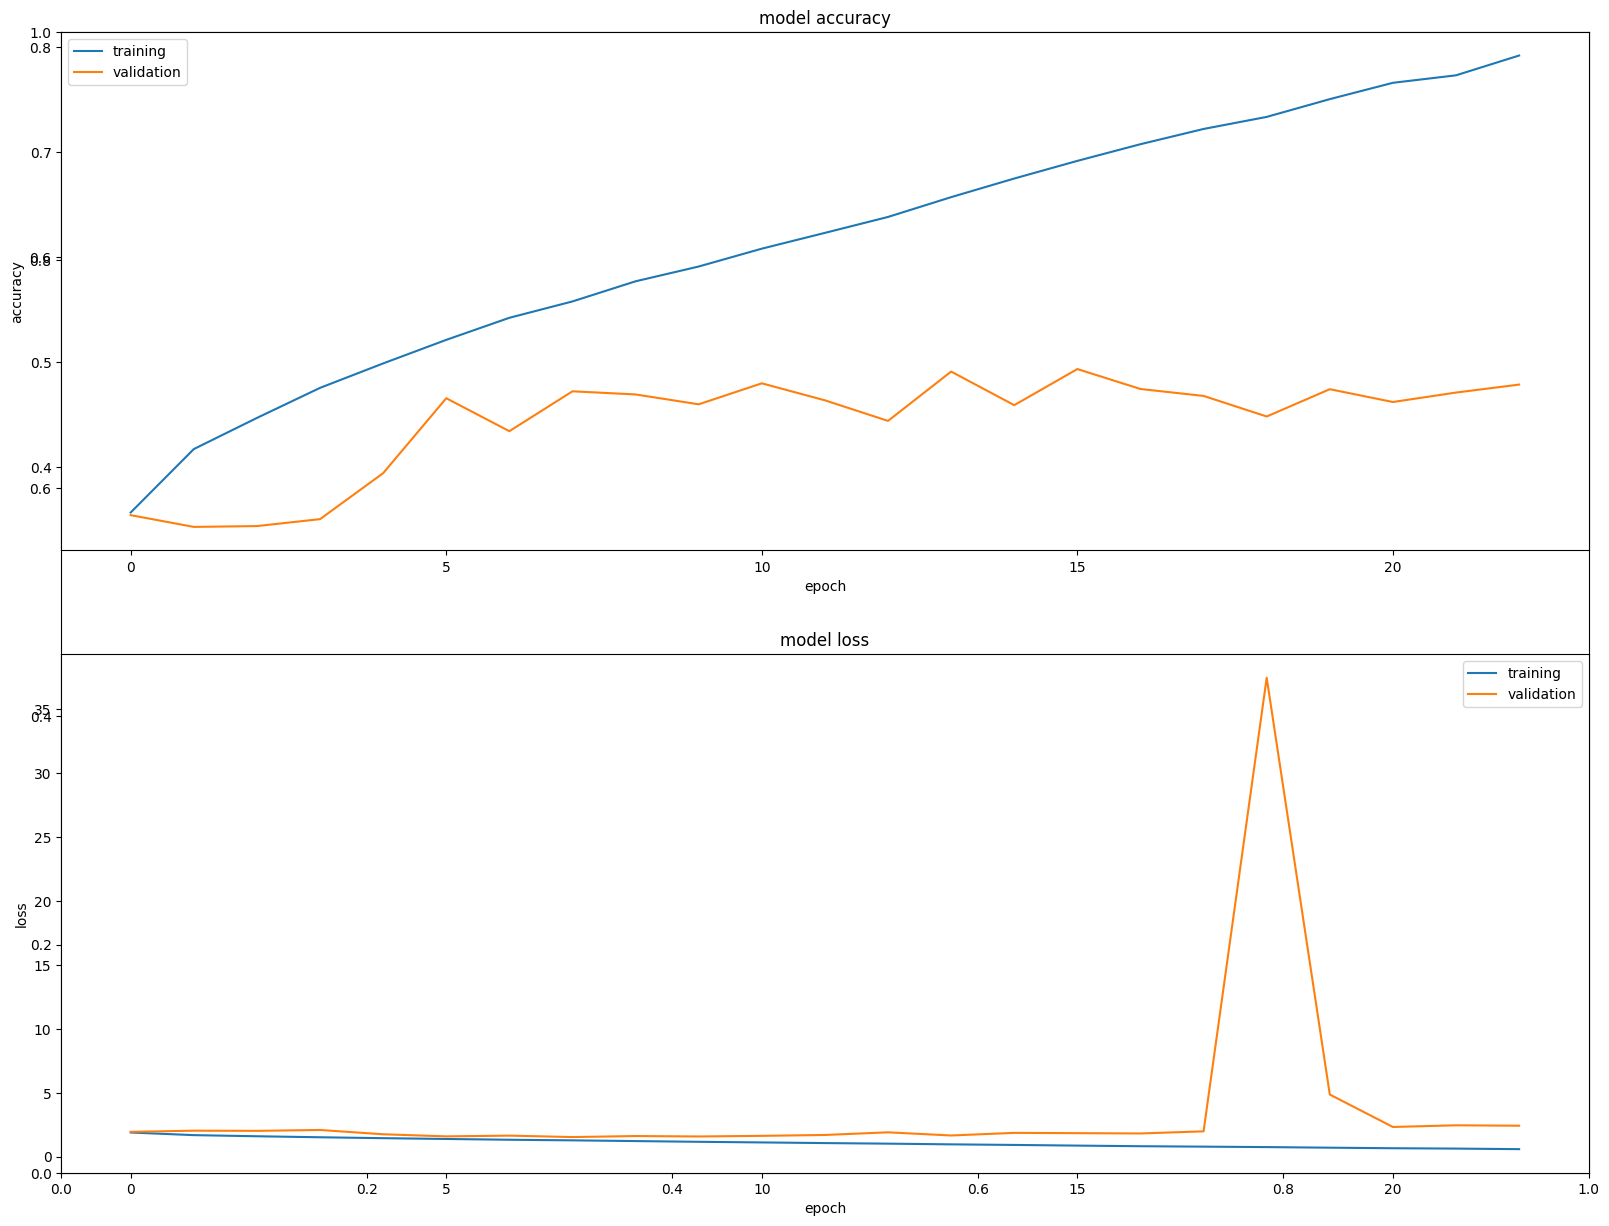

In [109]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_06.history['accuracy'], history_06.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_06.history['loss'], history_06.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [110]:
pred06_cm=np.argmax(pred06, axis=1)
print_validation_report(y_test, pred06_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.57      0.45      0.50      1000
           1       0.58      0.63      0.61      1000
           2       0.32      0.51      0.40      1000
           3       0.33      0.36      0.35      1000
           4       0.51      0.25      0.33      1000
           5       0.42      0.37      0.40      1000
           6       0.61      0.43      0.50      1000
           7       0.51      0.62      0.56      1000
           8       0.66      0.57      0.62      1000
           9       0.49      0.63      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.50      0.48      0.48     10000
weighted avg       0.50      0.48      0.48     10000

Accuracy Score: 0.4834
Root Mean Square Error: 3.1218103722039237


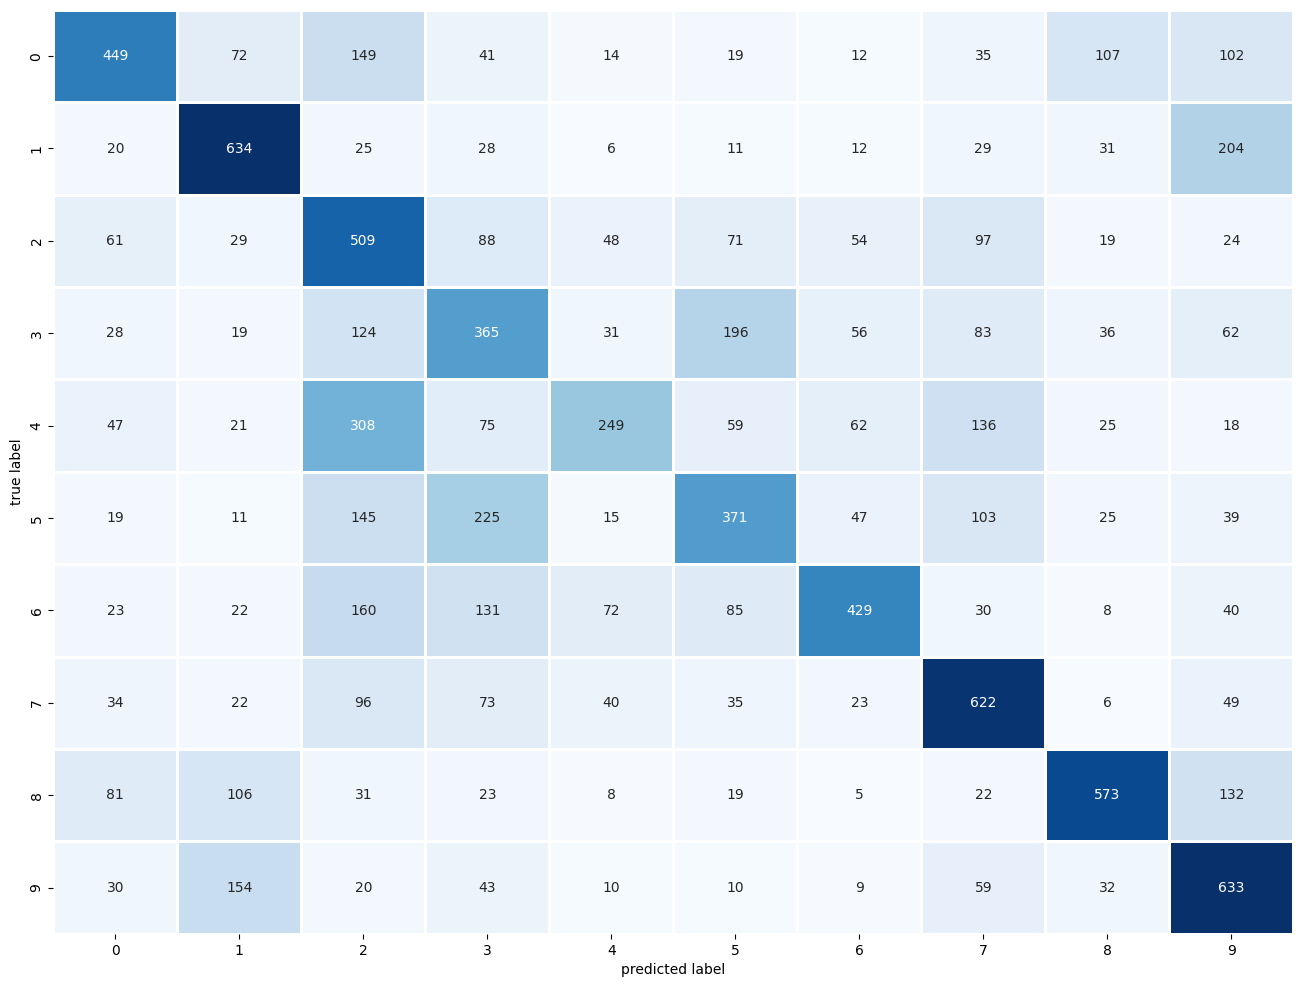

In [111]:
plot_confusion_matrix(y_test,pred06_cm)

In [112]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred06[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [113]:
layer_names = []
for layer in model_06.layers:
    layer_names.append(layer.name)

layer_names

['flatten',
 'dense',
 'batch_normalization',
 'dense_1',
 'batch_normalization_1',
 'dense_2',
 'batch_normalization_2',
 'dense_3']

In [114]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_06.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_06 = tf.keras.models.Model(inputs=model_06.input, outputs=layer_outputs)

# Get activation values for the last dense layer
# activations_06 = activation_model_06.predict(x_valid_norm[:3250])
activations_06 = activation_model_06.predict(x_valid_norm[:1500])
dense_layer_activations_06 = activations_06[-3]
output_layer_activations_06 = activations_06[-1]

47/47 [==============================] - 0s 1ms/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [115]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_06 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_06 = tsne_06.fit_transform(dense_layer_activations_06)

# Scaling
tsne_results_06 = (tsne_results_06 - tsne_results_06.min()) / (tsne_results_06.max() - tsne_results_06.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 15.065521
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.312225
[t-SNE] KL divergence after 300 iterations: 1.695715


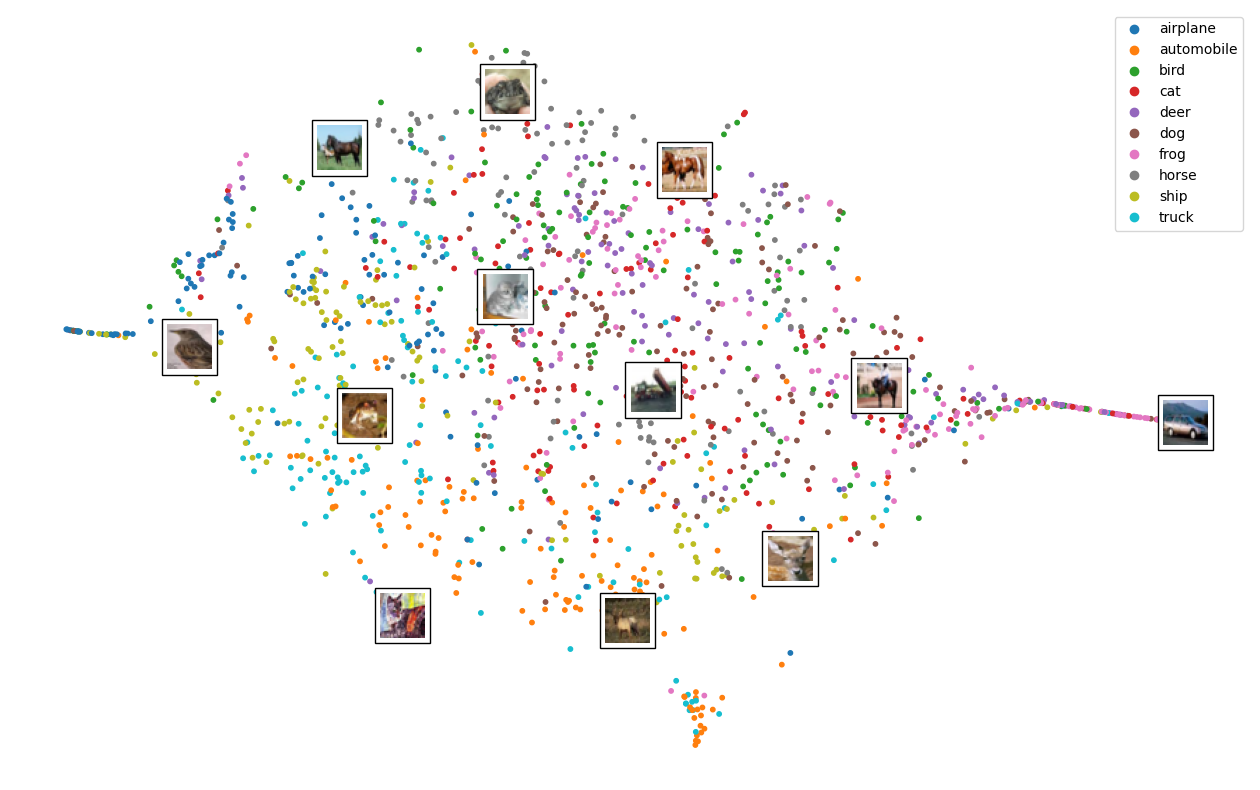

In [116]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_06[:,0],tsne_results_06[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_06[:,0],tsne_results_06[:,1], c=y_valid_split[:1500], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_06):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 7**

- CNN with 2 layers/max pooling layers
- L2 Regularization(0.001)

##### Build CNN Model

In [117]:
k.clear_session()
model_07 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
#  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
#  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment7"] = {}
results["Experiment7"]["Architecture"] = "• CNN with 2 layers/max pooling layers\n • L2 Regularization(0.001)"

In [118]:
model_07.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)               3

In [119]:
keras.utils.plot_model(model_07, "CIFAR10_EXP_07.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [120]:
model_07.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [121]:
# Start time
start_time = time.time()

history_07 = model_07.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_07_2CNN_BN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment7"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 4s 5ms/step - loss: 1.2678 - accuracy: 0.5580 - val_loss: 1.4533 - val_accuracy: 0.5008
Epoch 2/200
704/704 [==============================] - 3s 5ms/step - loss: 0.9628 - accuracy: 0.6645 - val_loss: 2.1573 - val_accuracy: 0.4074
Epoch 3/200
704/704 [==============================] - 3s 5ms/step - loss: 0.8284 - accuracy: 0.7144 - val_loss: 1.2960 - val_accuracy: 0.5830
Epoch 4/200
704/704 [==============================] - 3s 5ms/step - loss: 0.7231 - accuracy: 0.7514 - val_loss: 1.0535 - val_accuracy: 0.6364
Epoch 5/200
704/704 [==============================] - 3s 5ms/step - loss: 0.6363 - accuracy: 0.7792 - val_loss: 0.9151 - val_accuracy: 0.6892
Epoch 6/200
704/704 [==============================] - 3s 5ms/step - loss: 0.5506 - accuracy: 0.8075 - val_loss: 0.9850 - val_accuracy: 0.6806
Epoch 7/200
704/704 [==============================] - 3s 4ms/step - loss: 0.4700 - accuracy: 0.8357 - val_loss: 0.9247 - val_accuracy: 0.7110

In [122]:
train_loss = history_07.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_07.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_07.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_07.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_07 = tf.keras.models.load_model("A2_Exp_07_2CNN_BN.h5")
test_loss, test_accuracy = model_07.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment7"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment7"]["Test Loss"] = round(test_loss,3)
results["Experiment7"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment7"]["Train Loss"] = round(train_loss,3)
results["Experiment7"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment7"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.022, Training Accuracy: 0.993
Validation Loss: 1.894, Validation Accuracy: 0.724
Test Loss: 0.907, Test Accuracy: 0.701


In [123]:
pred07 = model_07.predict(x_test_norm)
print('shape of preds: ', pred07.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


In [124]:
history_07_dict = history_07.history
history_07_df=pd.DataFrame(history_07_dict)
history_07_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
40  0.026     0.992     1.769         0.722
41  0.015     0.995     2.028         0.697
42  0.032     0.989     2.124         0.705
43  0.038     0.988     1.779         0.721
44  0.022     0.993     1.894         0.724

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

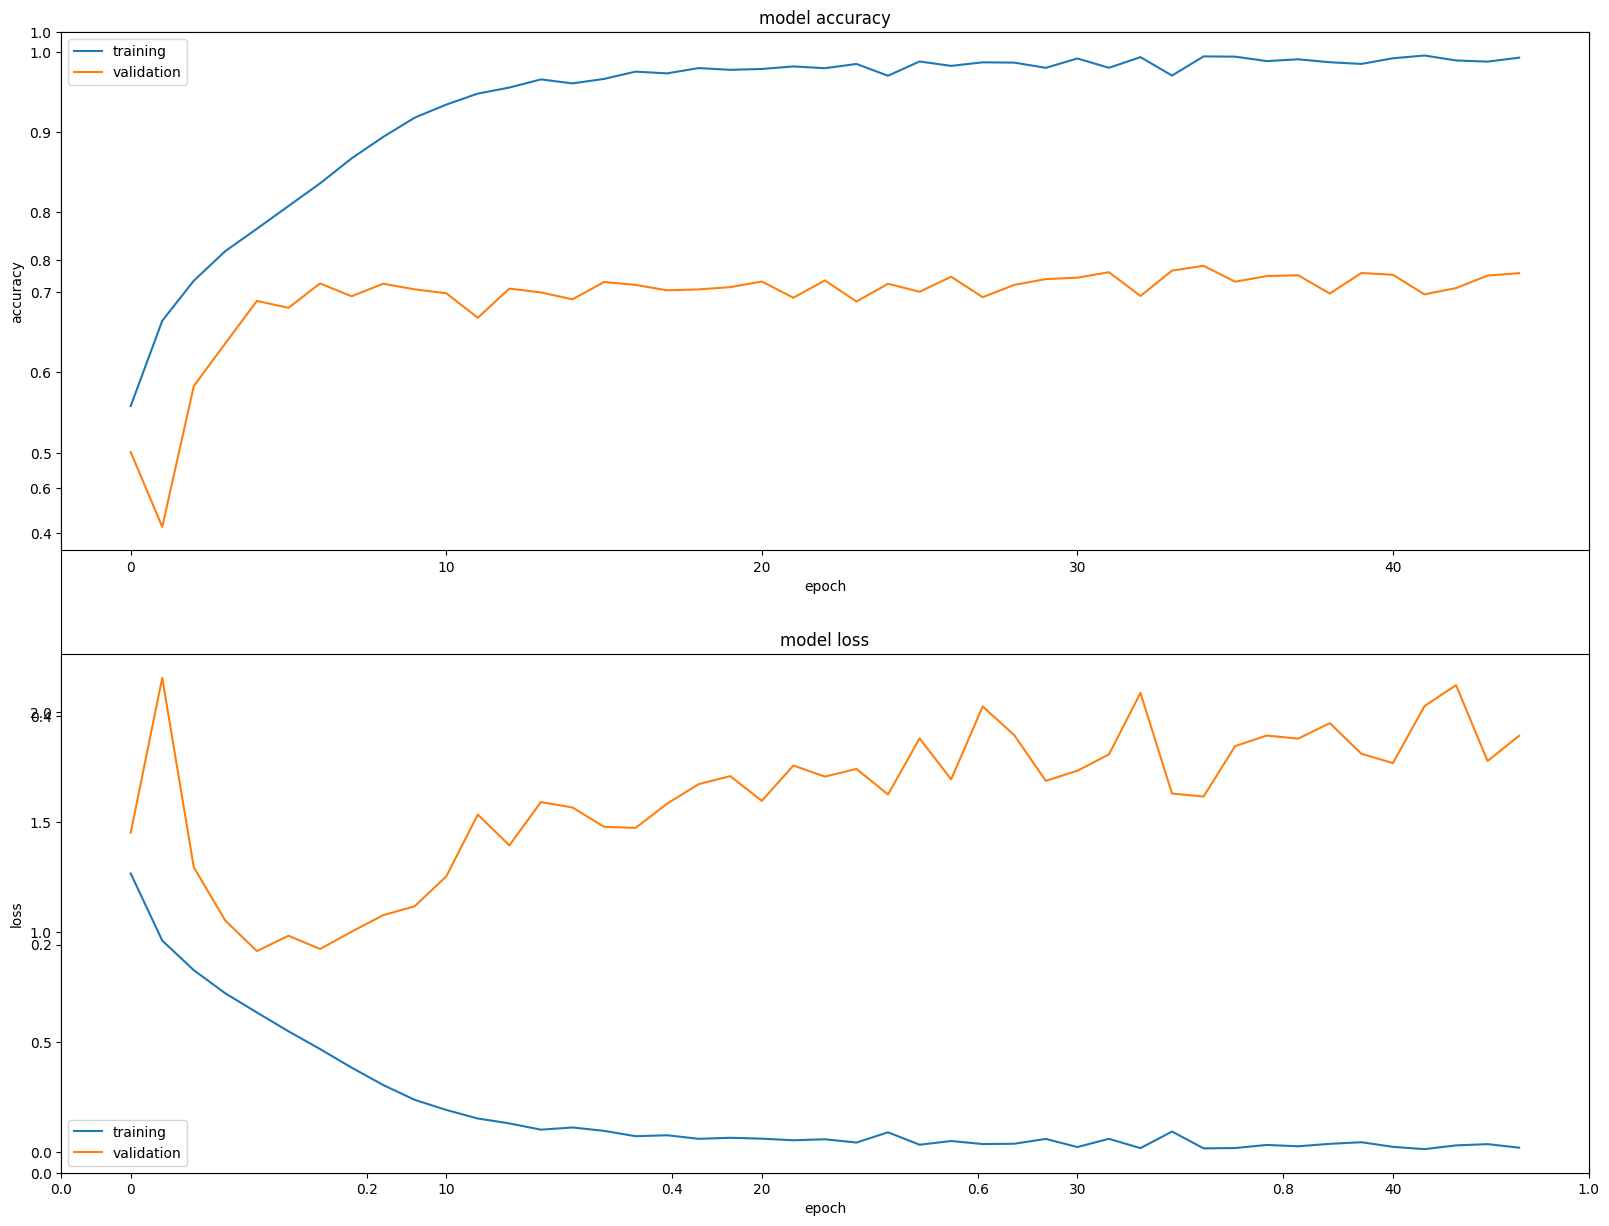

In [125]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_07.history['accuracy'], history_07.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_07.history['loss'], history_07.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [126]:
pred07_cm=np.argmax(pred07, axis=1)
print_validation_report(y_test, pred07_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.64      0.72      1000
           1       0.86      0.82      0.84      1000
           2       0.61      0.57      0.59      1000
           3       0.42      0.72      0.53      1000
           4       0.74      0.61      0.67      1000
           5       0.63      0.61      0.62      1000
           6       0.70      0.84      0.76      1000
           7       0.88      0.64      0.74      1000
           8       0.86      0.77      0.81      1000
           9       0.82      0.79      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.73      0.70      0.71     10000
weighted avg       0.73      0.70      0.71     10000

Accuracy Score: 0.7008
Root Mean Square Error: 2.1608100332976985


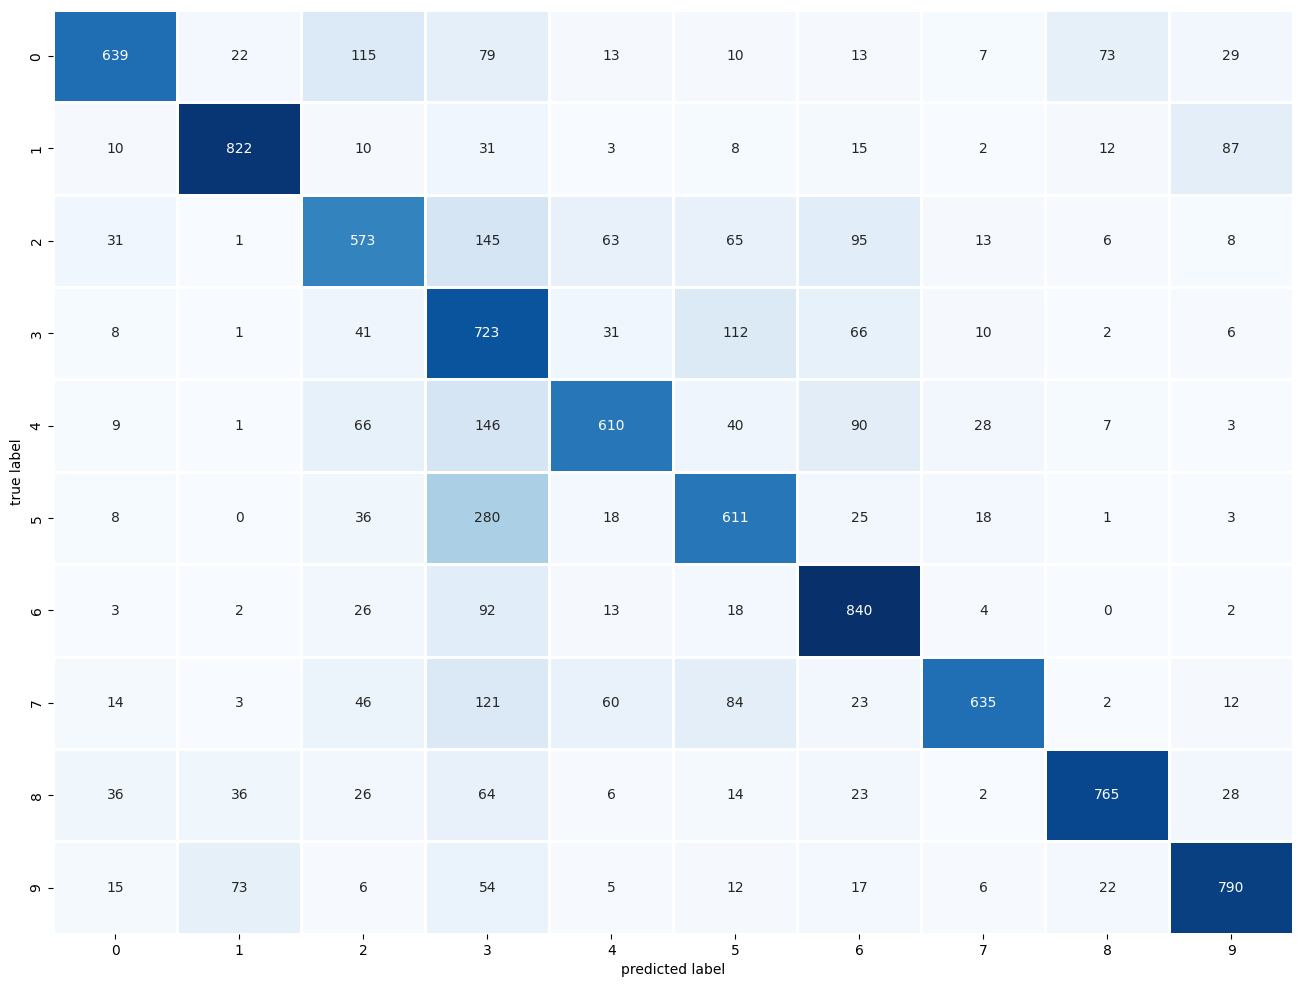

In [127]:
plot_confusion_matrix(y_test,pred07_cm)

In [128]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred07[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [129]:
layer_names = []
for layer in model_07.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'batch_normalization',
 'dense_1']

## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [130]:
# Extracts the outputs of the top 8 layers:
layer_outputs_07 = [layer.output for layer in model_07.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_07 = tf.keras.models.Model(inputs=model_07.input, outputs=layer_outputs_07)

# Get activation values for the last dense layer
# activations_07 = activation_model_07.predict(x_valid_norm[:3250])
activations_07 = activation_model_07.predict(x_valid_norm[:1200])
dense_layer_activations_07 = activations_07[-3]
output_layer_activations_07 = activations_07[-1]

38/38 [==============================] - 0s 2ms/step


In [131]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_07 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_07 = tsne_07.fit_transform(dense_layer_activations_07)

# Scaling
tsne_results_07 = (tsne_results_07 - tsne_results_07.min()) / (tsne_results_07.max() - tsne_results_07.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 1.826008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.998062
[t-SNE] KL divergence after 300 iterations: 1.695120


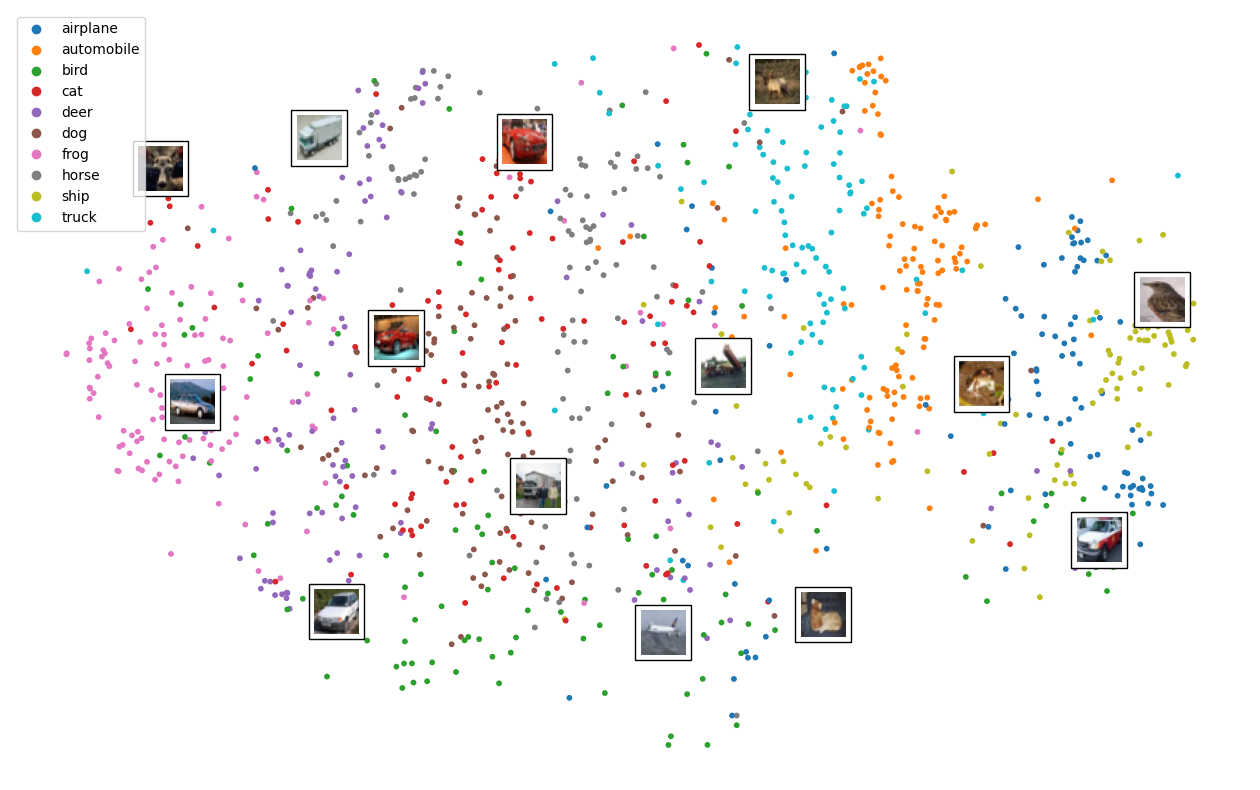

In [132]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_07[:,0],tsne_results_07[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_07[:,0],tsne_results_07[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_07):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 8**

- CNN with 3 layers/max pooling layers
- L2 Regularization(0.001)

##### Build CNN Model

In [133]:
k.clear_session()
model_08 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
#  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu),
#  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
#  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment8"] = {}
results["Experiment8"]["Architecture"] = "• CNN with 3 layers/max pooling layers\n • L2 Regularization(0.001)"

In [134]:
model_08.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 512)         0

In [135]:
keras.utils.plot_model(model_08, "CIFAR10_EXP_08.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [136]:
model_08.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [137]:
# Start time
start_time = time.time()

history_08 = model_08.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_08_3CNN_BN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment8"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200
704/704 [==============================] - 5s 5ms/step - loss: 1.2948 - accuracy: 0.5441 - val_loss: 1.4855 - val_accuracy: 0.4982
Epoch 2/200
704/704 [==============================] - 3s 5ms/step - loss: 0.9491 - accuracy: 0.6704 - val_loss: 1.4875 - val_accuracy: 0.5378
Epoch 3/200
704/704 [==============================] - 3s 5ms/step - loss: 0.7888 - accuracy: 0.7269 - val_loss: 1.0235 - val_accuracy: 0.6504
Epoch 4/200
704/704 [==============================] - 3s 5ms/step - loss: 0.6651 - accuracy: 0.7691 - val_loss: 1.9600 - val_accuracy: 0.4948
Epoch 5/200
704/704 [==============================] - 3s 5ms/step - loss: 0.5654 - accuracy: 0.8034 - val_loss: 0.9799 - val_accuracy: 0.6866
Epoch 6/200
704/704 [==============================] - 3s 5ms/step - loss: 0.4630 - accuracy: 0.8384 - val_loss: 1.2166 - val_accuracy: 0.6458
Epoch 7/200
704/704 [==============================] - 3s 5ms/step - loss: 0.3849 - accuracy: 0.8667 - val_loss: 1.0119 - val_accuracy: 0.7018

In [138]:
train_loss = history_08.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_08.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_08.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_08.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_08 = tf.keras.models.load_model("A2_Exp_08_3CNN_BN.h5")
test_loss, test_accuracy = model_08.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment8"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment8"]["Test Loss"] = round(test_loss,3)
results["Experiment8"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment8"]["Train Loss"] = round(train_loss,3)
results["Experiment8"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment8"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.047, Training Accuracy: 0.984
Validation Loss: 2.117, Validation Accuracy: 0.701
Test Loss: 0.944, Test Accuracy: 0.699


In [139]:
pred08 = model_08.predict(x_test_norm)
print('shape of preds: ', pred08.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


In [140]:
history_08_dict = history_08.history
history_08_df=pd.DataFrame(history_08_dict)
history_08_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
25  0.076     0.974     1.888         0.706
26  0.038     0.987     1.591         0.714
27  0.055     0.981     1.715         0.719
28  0.056     0.981     1.831         0.717
29  0.047     0.984     2.117         0.701

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

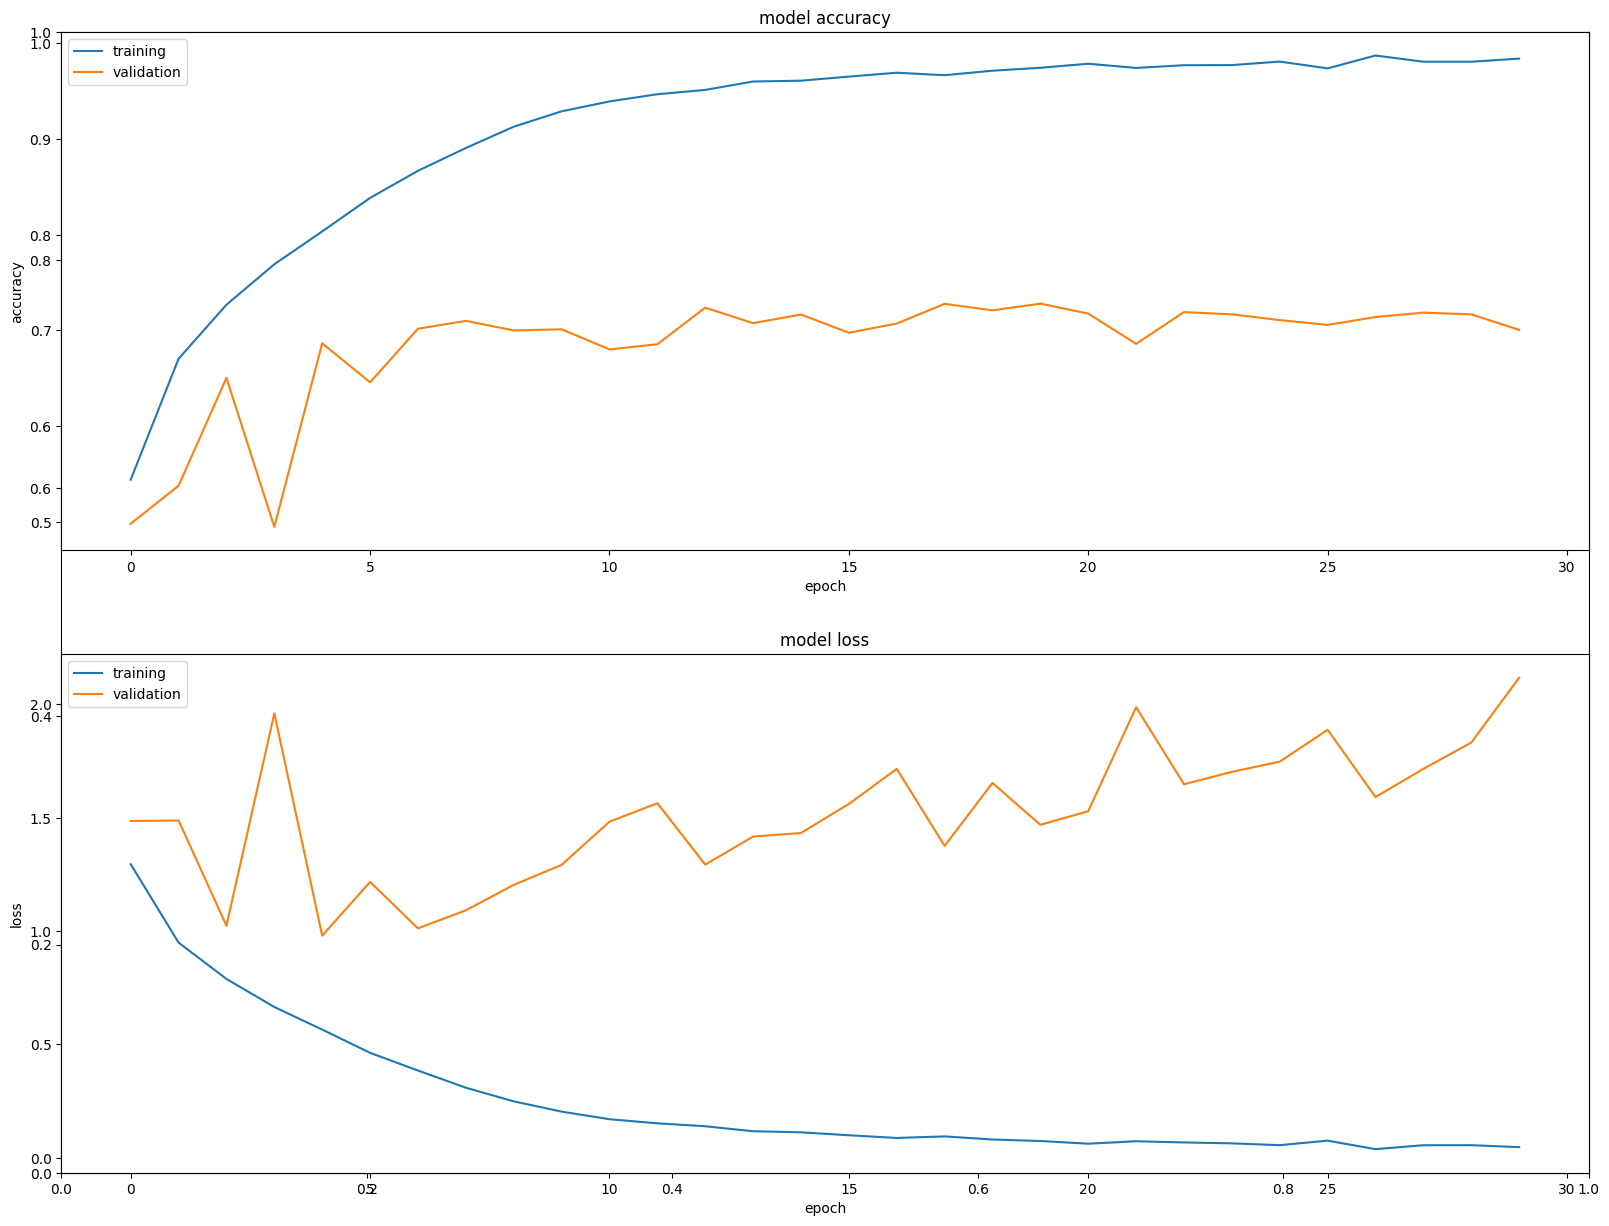

In [141]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_08.history['accuracy'], history_08.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_08.history['loss'], history_08.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [142]:
pred08_cm=np.argmax(pred08, axis=1)
print_validation_report(y_test, pred08_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1000
           1       0.95      0.71      0.81      1000
           2       0.65      0.65      0.65      1000
           3       0.46      0.72      0.56      1000
           4       0.75      0.62      0.68      1000
           5       0.70      0.55      0.61      1000
           6       0.86      0.75      0.80      1000
           7       0.93      0.61      0.74      1000
           8       0.56      0.96      0.71      1000
           9       0.85      0.73      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.74      0.70      0.70     10000
weighted avg       0.74      0.70      0.70     10000

Accuracy Score: 0.6988
Root Mean Square Error: 2.30967530185522


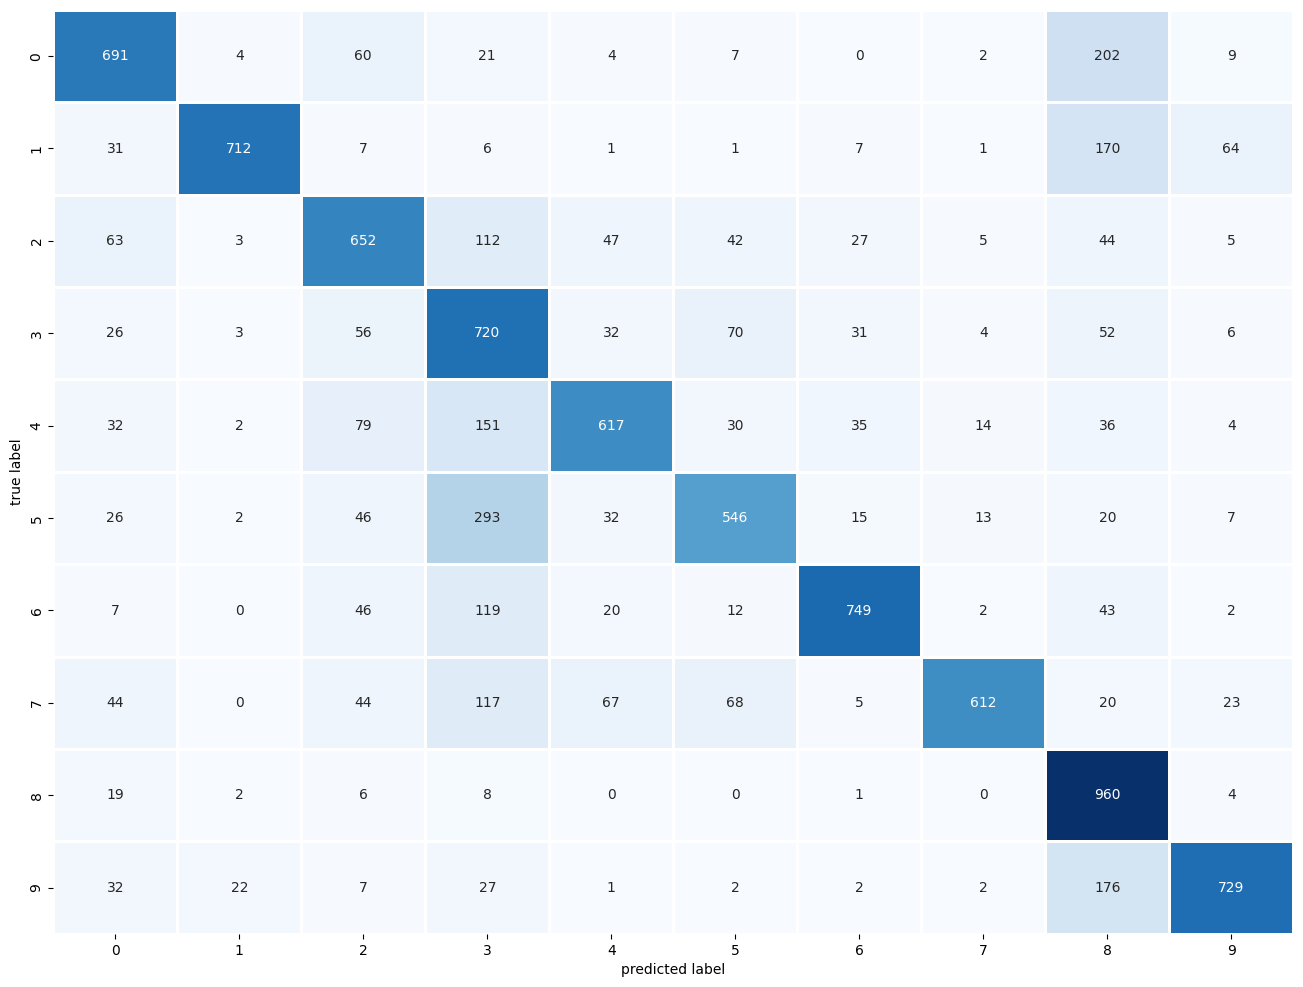

In [143]:
plot_confusion_matrix(y_test,pred08_cm)

In [144]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred08[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [145]:
layer_names = []
for layer in model_08.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dense_1']

In [146]:
# Extracts the outputs of the top 11 layers:
layer_outputs_08 = [layer.output for layer in model_08.layers[:10]]
# Creates a model that will return these outputs, given the model input:
activation_model_08 = tf.keras.models.Model(inputs=model_08.input, outputs=layer_outputs_08)

# Get activation values for the last dense layer
# activations_08 = activation_model_08.predict(x_valid_norm[:3250])
activations_08 = activation_model_08.predict(x_valid_norm[:1200])
dense_layer_activations_08 = activations_08[-3]
output_layer_activations_08 = activations_08[-1]

38/38 [==============================] - 0s 1ms/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [147]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_08 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_08 = tsne_08.fit_transform(dense_layer_activations_08)

# Scaling
tsne_results_08 = (tsne_results_08 - tsne_results_08.min()) / (tsne_results_08.max() - tsne_results_08.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 2.350581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.708244
[t-SNE] KL divergence after 300 iterations: 1.568058


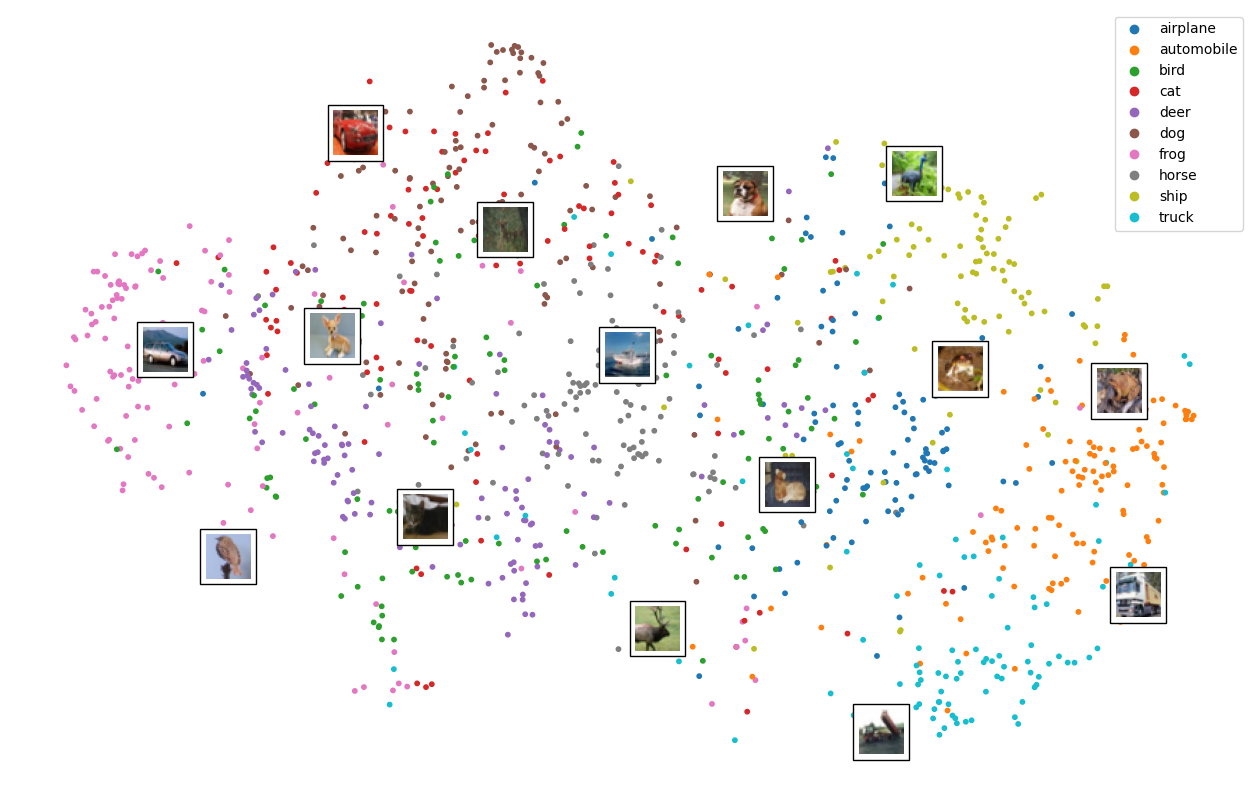

In [148]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_08[:,0],tsne_results_08[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_08[:,0],tsne_results_08[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_08):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## **Experiment 9**

- CNN with 3 layers/max pooling layers
- Dropout(0.3)
- L2 Regularization(0.001)
- Batch Normalization

##### Build CNN Model

In [149]:
k.clear_session()
model_09 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
#  Dense(units=384,activation=tf.nn.relu),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment9"] = {}
results["Experiment9"]["Architecture"] = "• CNN with 3 layers/max pooling layers\n • Dropout(0.3)\n • L2 Regularization(0.001)\n • Batch Normalization"

In [150]:
model_09.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [151]:
keras.utils.plot_model(model_09, "CIFAR10_EXP_09.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [152]:
model_09.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [153]:
# Start time
start_time = time.time()

history_09 = model_09.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_09_3CNN_DO_L2_BN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )
# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment9"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200


2024-10-20 03:52:59.267326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


704/704 [==============================] - 6s 6ms/step - loss: 1.9834 - accuracy: 0.4108 - val_loss: 1.6030 - val_accuracy: 0.4954
Epoch 2/200
704/704 [==============================] - 4s 5ms/step - loss: 1.4095 - accuracy: 0.5593 - val_loss: 1.4080 - val_accuracy: 0.5346
Epoch 3/200
704/704 [==============================] - 4s 5ms/step - loss: 1.2251 - accuracy: 0.6155 - val_loss: 1.2170 - val_accuracy: 0.6228
Epoch 4/200
704/704 [==============================] - 4s 5ms/step - loss: 1.1422 - accuracy: 0.6431 - val_loss: 1.1869 - val_accuracy: 0.6390
Epoch 5/200
704/704 [==============================] - 4s 5ms/step - loss: 1.0826 - accuracy: 0.6668 - val_loss: 1.0311 - val_accuracy: 0.6880
Epoch 6/200
704/704 [==============================] - 4s 5ms/step - loss: 1.0340 - accuracy: 0.6892 - val_loss: 1.0256 - val_accuracy: 0.6892
Epoch 7/200
704/704 [==============================] - 4s 5ms/step - loss: 1.0030 - accuracy: 0.7022 - val_loss: 0.9803 - val_accuracy: 0.7124
Epoch 8/200

In [154]:
train_loss = history_09.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_09.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_09.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_09.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_09 = tf.keras.models.load_model("A2_Exp_09_3CNN_DO_L2_BN.h5")
test_loss, test_accuracy = model_09.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment9"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment9"]["Test Loss"] = round(test_loss,3)
results["Experiment9"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment9"]["Train Loss"] = round(train_loss,3)
results["Experiment9"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment9"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.574, Training Accuracy: 0.853
Validation Loss: 0.746, Validation Accuracy: 0.795
Test Loss: 0.743, Test Accuracy: 0.798


In [155]:
pred09 = model_09.predict(x_test_norm)
print('shape of preds: ', pred09.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


In [156]:
history_09_dict = history_09.history
history_09_df=pd.DataFrame(history_09_dict)
history_09_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
44  0.593     0.847     0.738         0.802
45  0.589     0.847     0.775         0.794
46  0.581     0.852     0.769         0.795
47  0.578     0.851     0.753         0.797
48  0.574     0.853     0.746         0.795

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

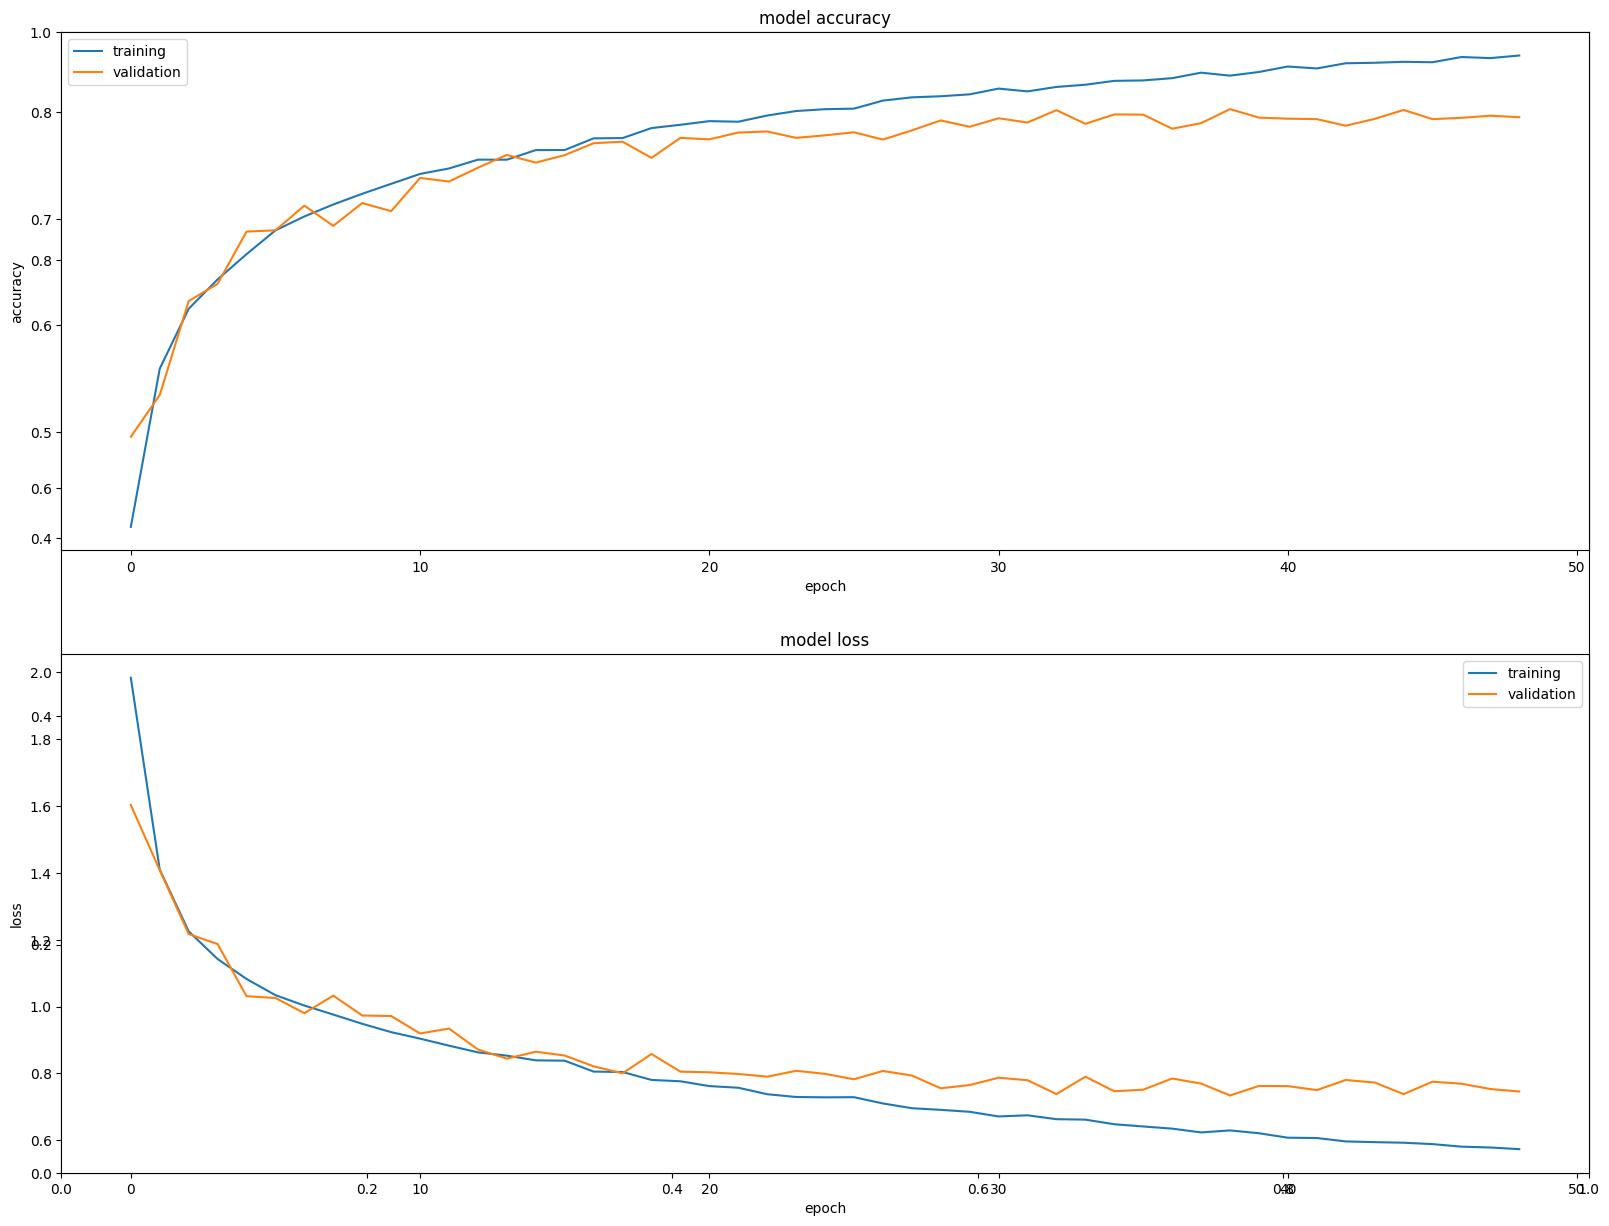

In [157]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_09.history['accuracy'], history_09.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_09.history['loss'], history_09.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [158]:
pred09_cm=np.argmax(pred09, axis=1)
print_validation_report(y_test, pred09_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1000
           1       0.92      0.89      0.90      1000
           2       0.80      0.62      0.70      1000
           3       0.66      0.65      0.65      1000
           4       0.72      0.82      0.77      1000
           5       0.68      0.75      0.71      1000
           6       0.81      0.89      0.85      1000
           7       0.85      0.81      0.83      1000
           8       0.87      0.88      0.88      1000
           9       0.85      0.86      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Accuracy Score: 0.7976
Root Mean Square Error: 1.8043835512440252


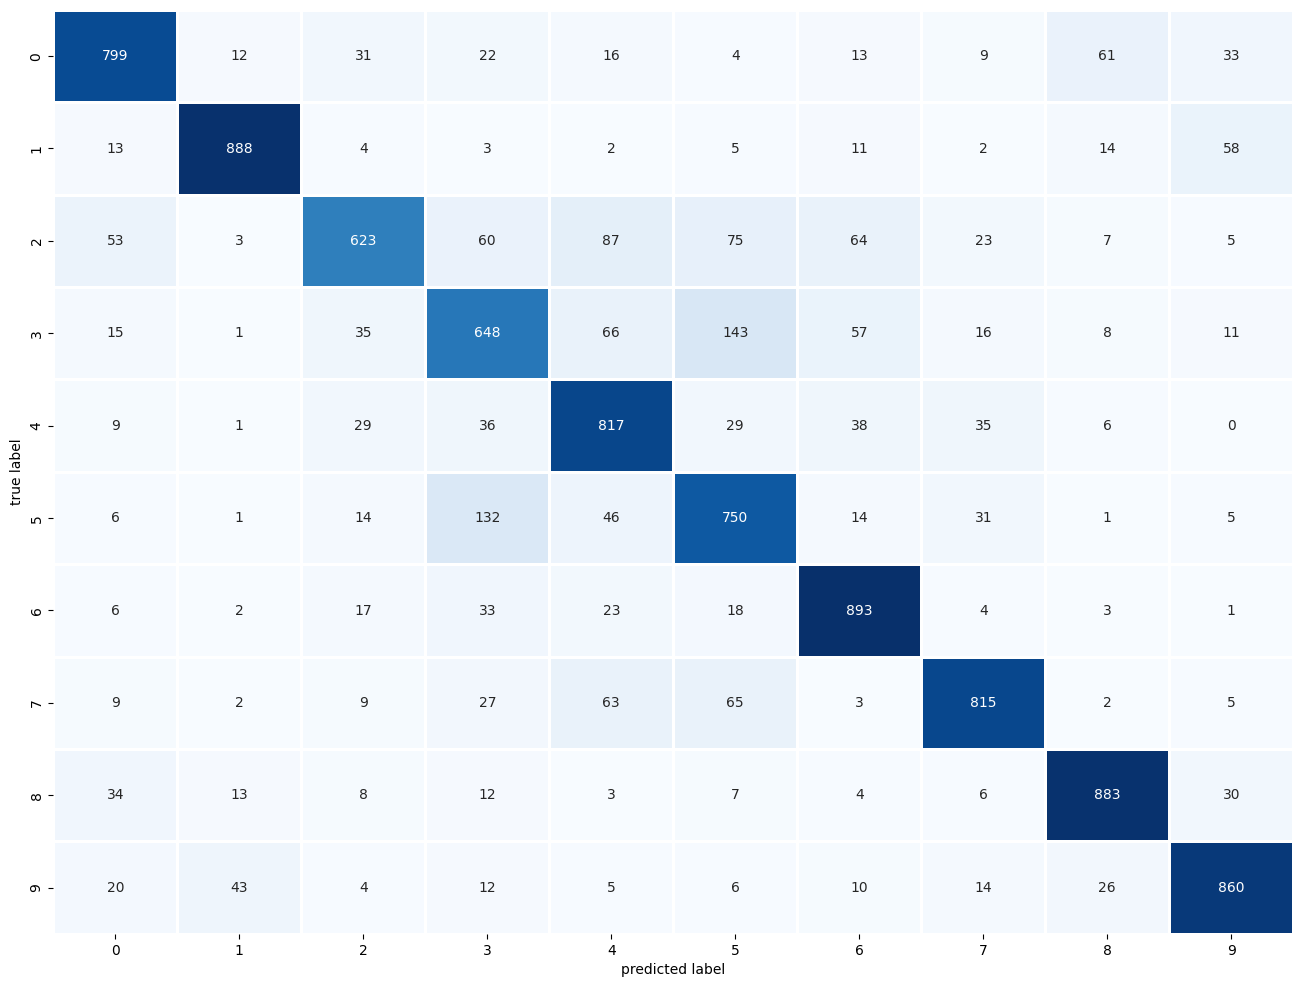

In [159]:
plot_confusion_matrix(y_test,pred09_cm)

In [160]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred09[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [161]:
layer_names = []
for layer in model_09.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1']

In [162]:
# Extracts the outputs of the top 11 layers:
layer_outputs_09 = [layer.output for layer in model_09.layers[:14]]
# Creates a model that will return these outputs, given the model input:
activation_model_09 = tf.keras.models.Model(inputs=model_09.input, outputs=layer_outputs_09)

# Get activation values for the last dense layer
# activations_09 = activation_model_09.predict(x_valid_norm[:3250])
activations_09 = activation_model_09.predict(x_valid_norm[:1200])
dense_layer_activations_09 = activations_09[-4]
output_layer_activations_09 = activations_09[-1]

38/38 [==============================] - 0s 1ms/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [163]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_09 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_09 = tsne_09.fit_transform(dense_layer_activations_09)

# Scaling
tsne_results_09 = (tsne_results_09 - tsne_results_09.min()) / (tsne_results_09.max() - tsne_results_09.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 2.847355
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.816189
[t-SNE] KL divergence after 300 iterations: 1.159818


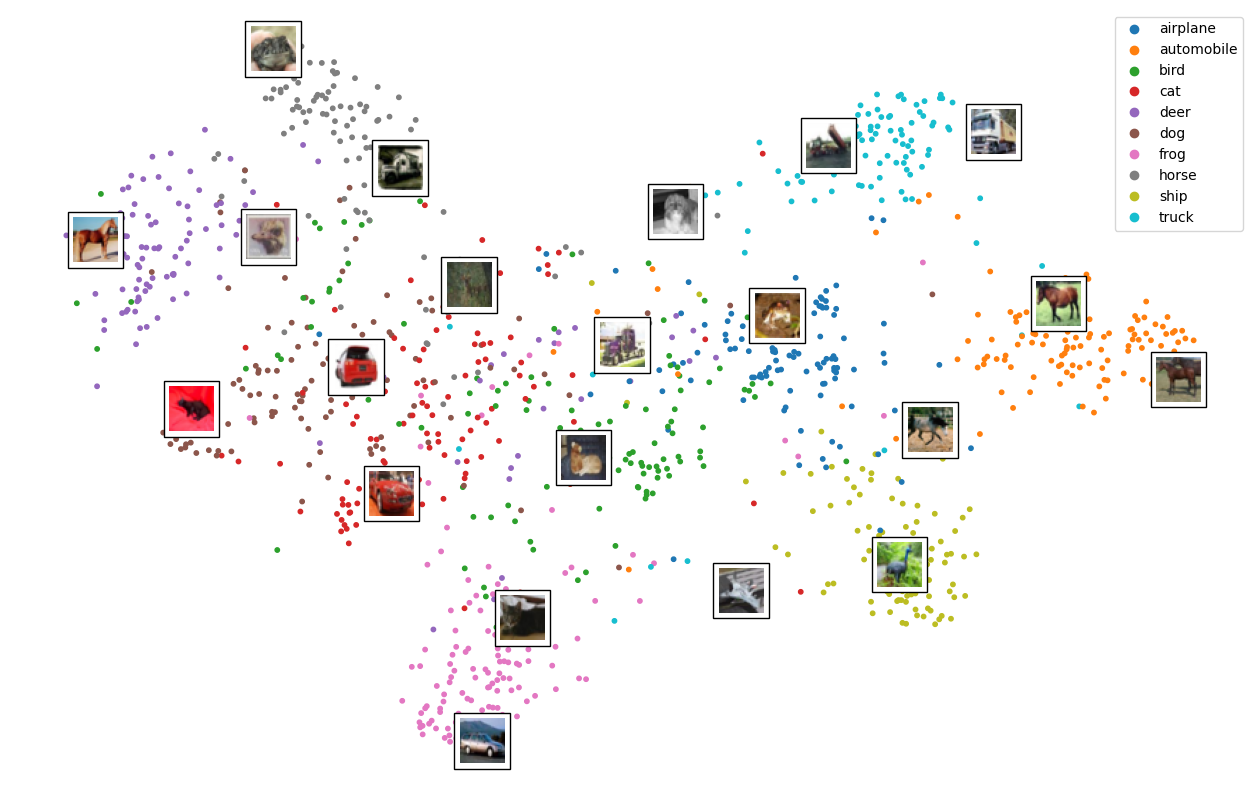

In [164]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_09[:,0],tsne_results_09[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_09[:,0],tsne_results_09[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_09):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 10

- CNN with 3 layers/max pooling layers
- 2 Fully-Connected Hidden Layers
- Dropout(0.3)
- L2 Regularization(0.001)
- Batch Normalization

##### Build CNN Model

In [165]:
k.clear_session()
model_10 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment10"] = {}
results["Experiment10"]["Architecture"] = "• CNN with 3 layers/max pooling layers\n • 2 Fully-Connected Hidden Layers\n • Dropout(0.3)\n • L2 Regularization(0.001)\n • Batch Normalization"

In [166]:
model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [167]:
keras.utils.plot_model(model_10, "CIFAR10_EXP_10.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [168]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [169]:
# Start time
start_time = time.time()

history_10 = model_10.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_10_3CNN_2DNN_DO_L2_BN.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )
# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment10"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200


2024-10-20 03:56:09.179894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


704/704 [==============================] - 6s 6ms/step - loss: 2.7633 - accuracy: 0.3147 - val_loss: 2.1523 - val_accuracy: 0.4300
Epoch 2/200
704/704 [==============================] - 4s 6ms/step - loss: 1.8389 - accuracy: 0.5035 - val_loss: 1.7617 - val_accuracy: 0.4958
Epoch 3/200
704/704 [==============================] - 4s 6ms/step - loss: 1.5069 - accuracy: 0.5783 - val_loss: 1.5316 - val_accuracy: 0.5566
Epoch 4/200
704/704 [==============================] - 4s 6ms/step - loss: 1.3299 - accuracy: 0.6196 - val_loss: 1.2661 - val_accuracy: 0.6322
Epoch 5/200
704/704 [==============================] - 4s 6ms/step - loss: 1.2306 - accuracy: 0.6470 - val_loss: 1.2873 - val_accuracy: 0.6304
Epoch 6/200
704/704 [==============================] - 4s 6ms/step - loss: 1.1748 - accuracy: 0.6653 - val_loss: 1.1088 - val_accuracy: 0.6808
Epoch 7/200
704/704 [==============================] - 4s 6ms/step - loss: 1.1309 - accuracy: 0.6852 - val_loss: 1.1560 - val_accuracy: 0.6680
Epoch 8/200

In [170]:
train_loss = history_10.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_10.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_10.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_10.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_10 = tf.keras.models.load_model("A2_Exp_10_3CNN_2DNN_DO_L2_BN.h5")
test_loss, test_accuracy = model_10.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment10"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment10"]["Test Loss"] = round(test_loss,3)
results["Experiment10"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment10"]["Train Loss"] = round(train_loss,3)
results["Experiment10"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment10"]["Validation Loss"] = round(val_loss,3)

Training Loss: 0.490, Training Accuracy: 0.880
Validation Loss: 0.772, Validation Accuracy: 0.804
Test Loss: 0.741, Test Accuracy: 0.811


In [171]:
pred10 = model_10.predict(x_test_norm)
print('shape of preds: ', pred10.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


In [172]:
history_10_dict = history_10.history
history_10_df=pd.DataFrame(history_10_dict)
history_10_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
65  0.505     0.876     0.784         0.800
66  0.501     0.877     0.777         0.802
67  0.500     0.879     0.766         0.799
68  0.491     0.882     0.741         0.808
69  0.490     0.880     0.772         0.804

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

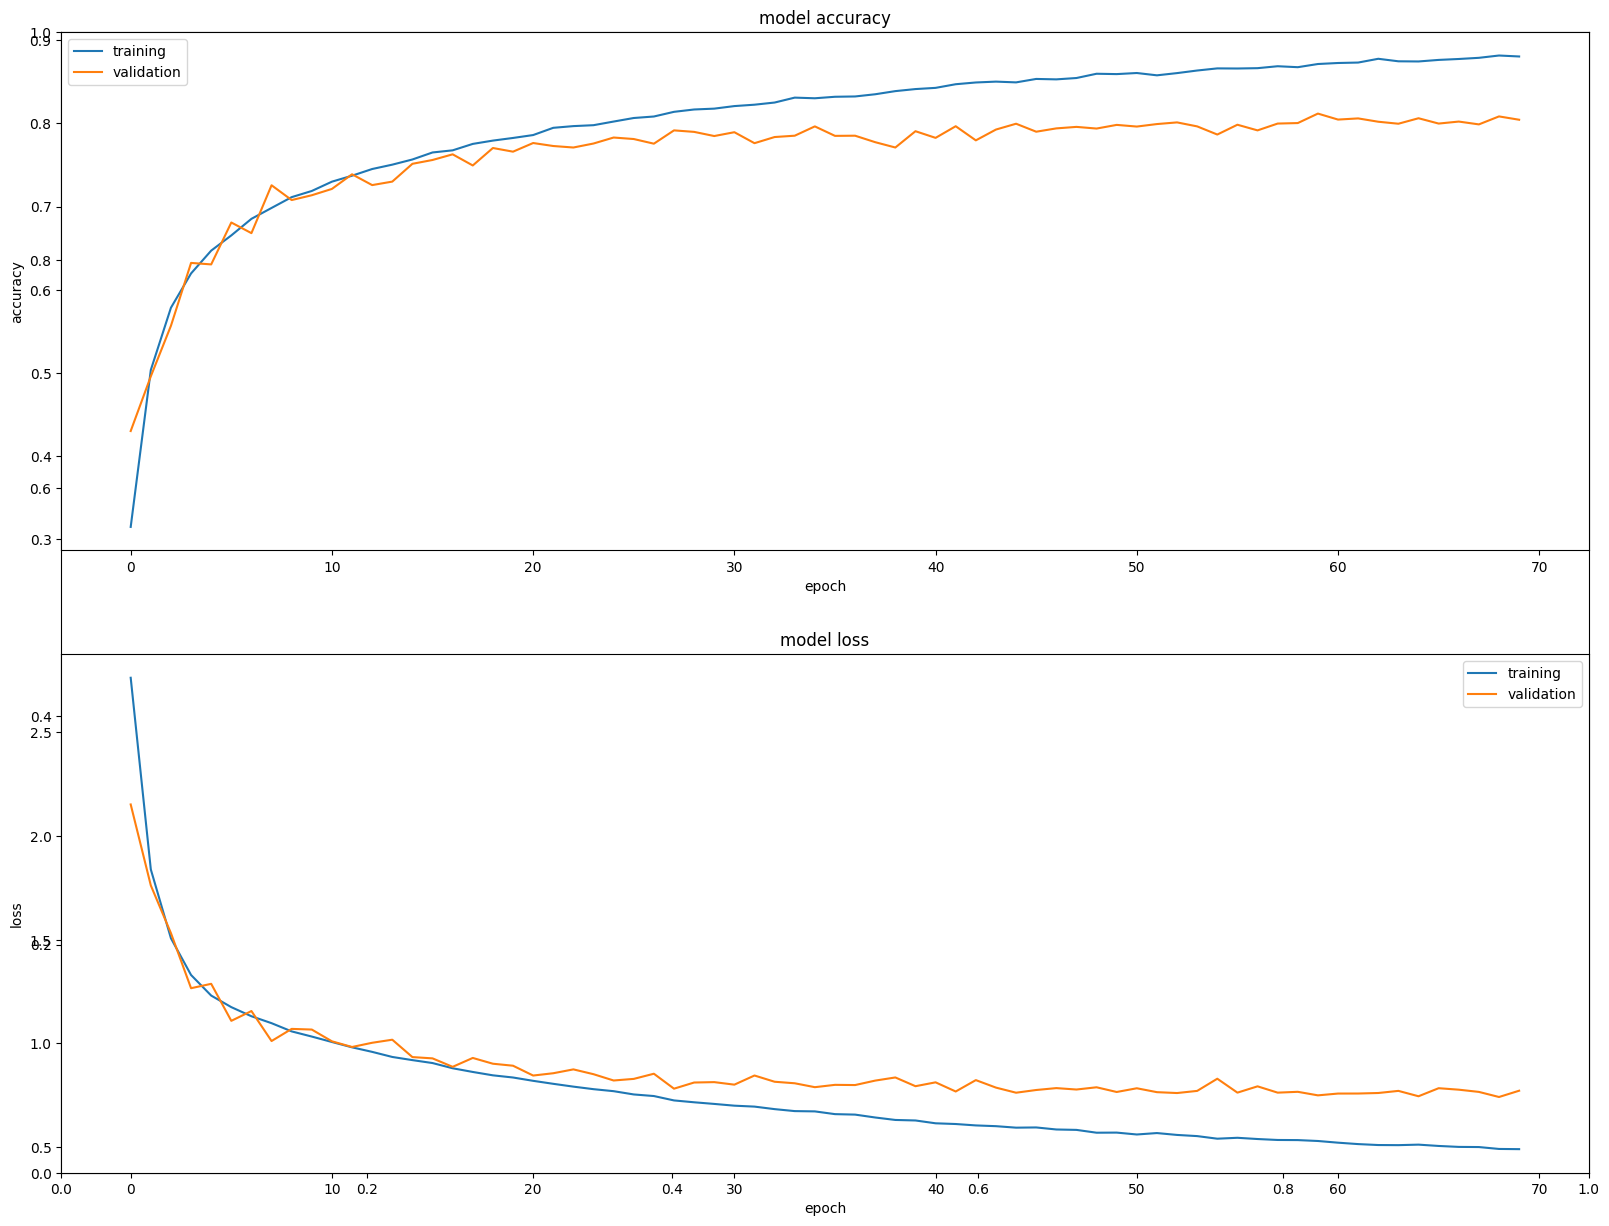

In [173]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [174]:
pred10_cm=np.argmax(pred10, axis=1)
print_validation_report(y_test, pred10_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1000
           1       0.92      0.90      0.91      1000
           2       0.80      0.67      0.73      1000
           3       0.68      0.65      0.66      1000
           4       0.72      0.83      0.77      1000
           5       0.76      0.73      0.75      1000
           6       0.83      0.89      0.86      1000
           7       0.85      0.82      0.83      1000
           8       0.91      0.86      0.89      1000
           9       0.83      0.91      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Accuracy Score: 0.8111
Root Mean Square Error: 1.7584652399180372


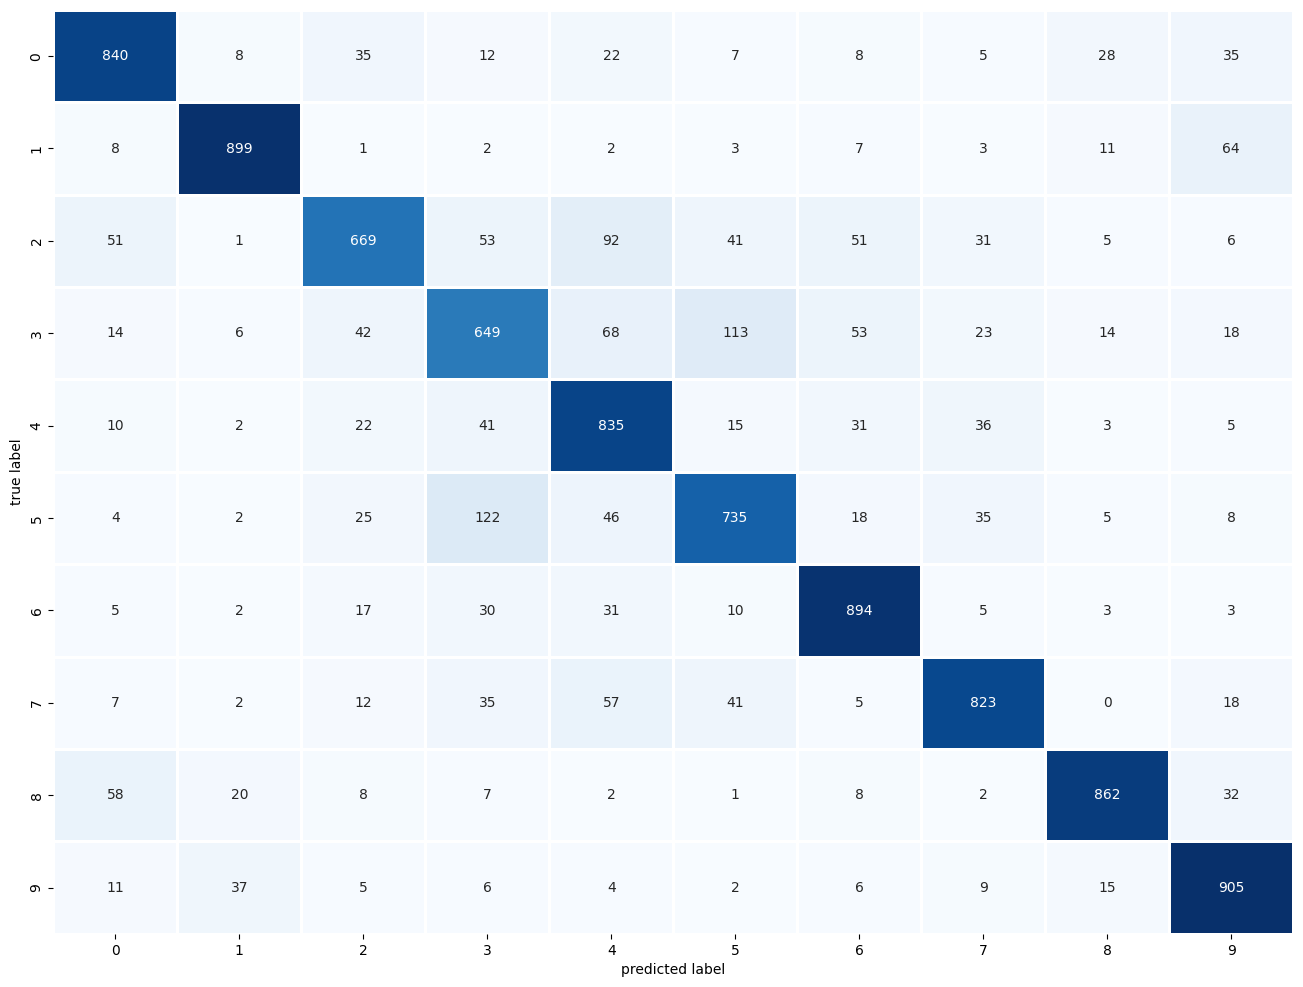

In [175]:
plot_confusion_matrix(y_test,pred10_cm)

In [176]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred10[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [177]:
layer_names = []
for layer in model_10.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1',
 'batch_normalization_1',
 'dropout_4',
 'dense_2']

In [178]:
# Extracts the outputs of the top 11 layers:
layer_outputs_10 = [layer.output for layer in model_10.layers[:14]]
# Creates a model that will return these outputs, given the model input:
activation_model_10 = tf.keras.models.Model(inputs=model_10.input, outputs=layer_outputs_10)

# Get activation values for the last dense layer
# activations_10 = activation_model_10.predict(x_valid_norm[:3250])
activations_10 = activation_model_10.predict(x_valid_norm[:1200])
dense_layer_activations_10 = activations_10[-4]
output_layer_activations_10 = activations_10[-1]

38/38 [==============================] - 0s 1ms/step


## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [179]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_10 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_10 = tsne_10.fit_transform(dense_layer_activations_10)

# Scaling
tsne_results_10 = (tsne_results_10 - tsne_results_10.min()) / (tsne_results_10.max() - tsne_results_10.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.000s...
[t-SNE] Computed neighbors for 1200 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 6.276072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.099758
[t-SNE] KL divergence after 300 iterations: 0.962577


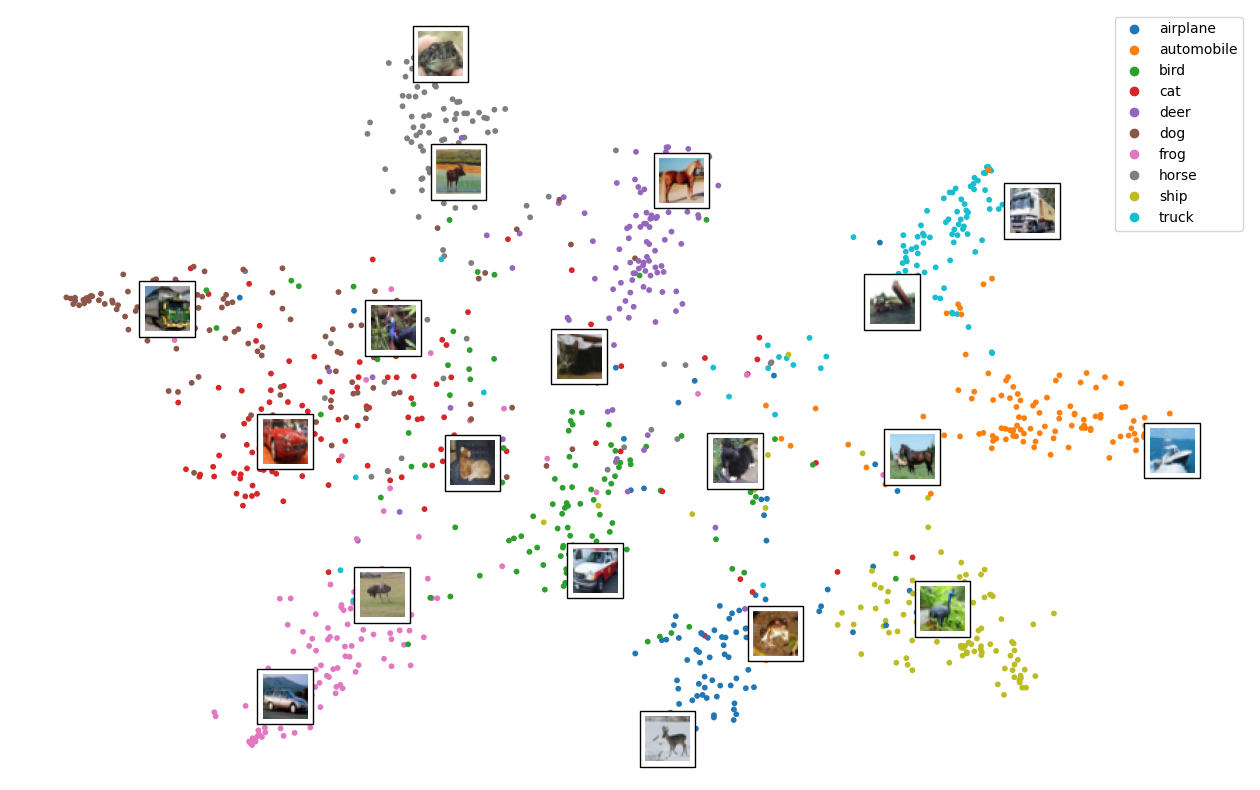

In [180]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_10[:,0],tsne_results_10[:,1], c=y_valid_split[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_10[:,0],tsne_results_10[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_10):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 11 - TWEAK Hyperparameters

- CNN with 3 layers/max pooling layers
- 2 Fully-Connected Hidden Layers (384, 768)
- Dropout(variable)
- L2 Regularization(variable)
- Batch Normalization

In [181]:
l2_rate = 0.001
dropout_rate = 0.5

##### Build CNN Model

In [182]:
k.clear_session()
model_11 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(dropout_rate),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(dropout_rate),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(dropout_rate),
  Flatten(),
  Dense(units=384,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(l2_rate)),
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(units=768,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(l2_rate)),
  BatchNormalization(),
  Dropout(dropout_rate),
  Dense(units=10, activation=tf.nn.softmax)
])
results["Experiment11"] = {}
results["Experiment11"]["Architecture"] = "• CNN with 3 layers/max pooling layers\n • 2 Fully-Connected Hidden Layers\n • Dropout(variable)\n • L2 Regularization(0.001)\n • Batch Normalization"

In [183]:
model_11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

In [184]:
keras.utils.plot_model(model_11, "CIFAR10_EXP_11_TWEAK.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [185]:
model_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Model Train

In [187]:
# Start time
start_time = time.time()

history_11 = model_11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,verbose=1
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("A2_Exp_11_3CNN_2DNN_BN_TWEAK_L2001_DO05.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
                    ]
                   )

# End time
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Time taken to train Model: {elapsed_time:.2f} seconds")
results["Experiment11"]["Train Time"] = str(round(elapsed_time, 2)) + ' seconds'

Epoch 1/200


2024-10-20 04:05:04.676861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


704/704 [==============================] - 6s 6ms/step - loss: 3.2646 - accuracy: 0.2181 - val_loss: 2.6560 - val_accuracy: 0.2834
Epoch 2/200
704/704 [==============================] - 4s 6ms/step - loss: 2.2898 - accuracy: 0.3897 - val_loss: 2.2724 - val_accuracy: 0.3714
Epoch 3/200
704/704 [==============================] - 4s 6ms/step - loss: 1.9079 - accuracy: 0.4693 - val_loss: 1.8766 - val_accuracy: 0.4700
Epoch 4/200
704/704 [==============================] - 4s 6ms/step - loss: 1.7136 - accuracy: 0.5144 - val_loss: 1.7722 - val_accuracy: 0.4950
Epoch 5/200
704/704 [==============================] - 4s 6ms/step - loss: 1.6062 - accuracy: 0.5435 - val_loss: 1.7477 - val_accuracy: 0.5028
Epoch 6/200
704/704 [==============================] - 4s 6ms/step - loss: 1.5422 - accuracy: 0.5663 - val_loss: 1.5872 - val_accuracy: 0.5442
Epoch 7/200
704/704 [==============================] - 4s 6ms/step - loss: 1.4910 - accuracy: 0.5862 - val_loss: 1.6825 - val_accuracy: 0.5234
Epoch 8/200

In [188]:
train_loss = history_11.history['loss'][-1]  # Training loss from the last epoch
train_accuracy = history_11.history['accuracy'][-1]  # Training accuracy from the last epoch
val_loss = history_11.history['val_loss'][-1]  # Validation loss from the last epoch
val_accuracy = history_11.history['val_accuracy'][-1]  # Validation accuracy from the last epoch

# Print training and validation metrics
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

model_11 = tf.keras.models.load_model("A2_Exp_11_3CNN_2DNN_BN_TWEAK_L2001_DO05.h5")
test_loss, test_accuracy = model_11.evaluate(x_test_norm, y_test, verbose=0)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

results["Experiment11"]["Test Accuracy"] = round(test_accuracy,3)
results["Experiment11"]["Test Loss"] = round(test_loss,3)
results["Experiment11"]["Train Accuracy"] = round(train_accuracy,3)
results["Experiment11"]["Train Loss"] = round(train_loss,3)
results["Experiment11"]["Validation Accuracy"] = round(val_accuracy,3)
results["Experiment11"]["Validation Loss"] = round(val_loss,3)

Training Loss: 1.046, Training Accuracy: 0.741
Validation Loss: 0.956, Validation Accuracy: 0.771
Test Loss: 0.944, Test Accuracy: 0.772


In [189]:
pred11 = model_11.predict(x_test_norm)
print('shape of preds: ', pred11.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


In [190]:
history_11_dict = history_11.history
history_11_df=pd.DataFrame(history_11_dict)
history_11_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
38  1.067     0.735     1.047         0.736
39  1.064     0.736     0.950         0.771
40  1.056     0.738     0.960         0.768
41  1.048     0.739     0.951         0.775
42  1.046     0.741     0.956         0.771

## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

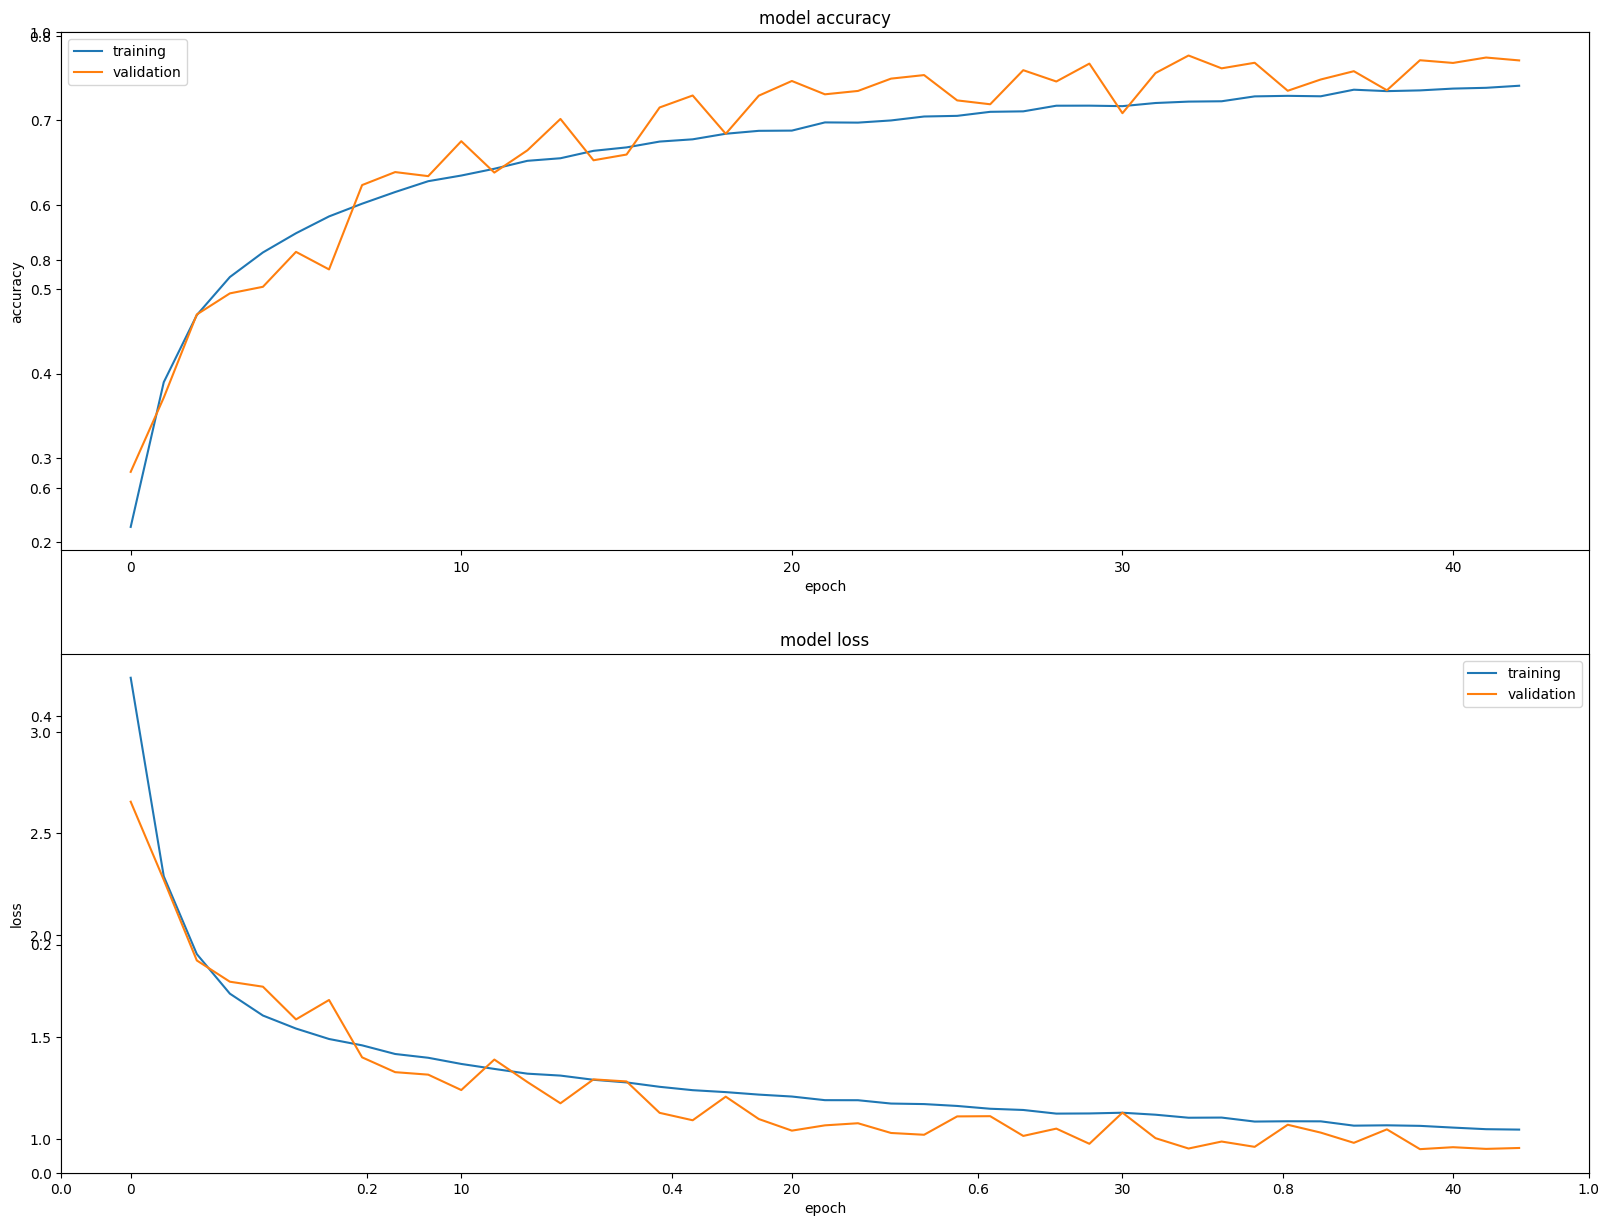

In [191]:
plt.subplots(figsize=(16,12)) # l2_rate = 0.001, dropout_rate = 0.5
plt.tight_layout()
display_training_curves(history_11.history['accuracy'], history_11.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_11.history['loss'], history_11.history['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [192]:
pred11_cm=np.argmax(pred11, axis=1)
print_validation_report(y_test, pred11_cm)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1000
           1       0.91      0.88      0.90      1000
           2       0.75      0.60      0.67      1000
           3       0.70      0.52      0.60      1000
           4       0.63      0.82      0.72      1000
           5       0.76      0.62      0.68      1000
           6       0.68      0.91      0.78      1000
           7       0.87      0.80      0.83      1000
           8       0.77      0.94      0.84      1000
           9       0.87      0.87      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Accuracy Score: 0.7717
Root Mean Square Error: 1.9351485731075018


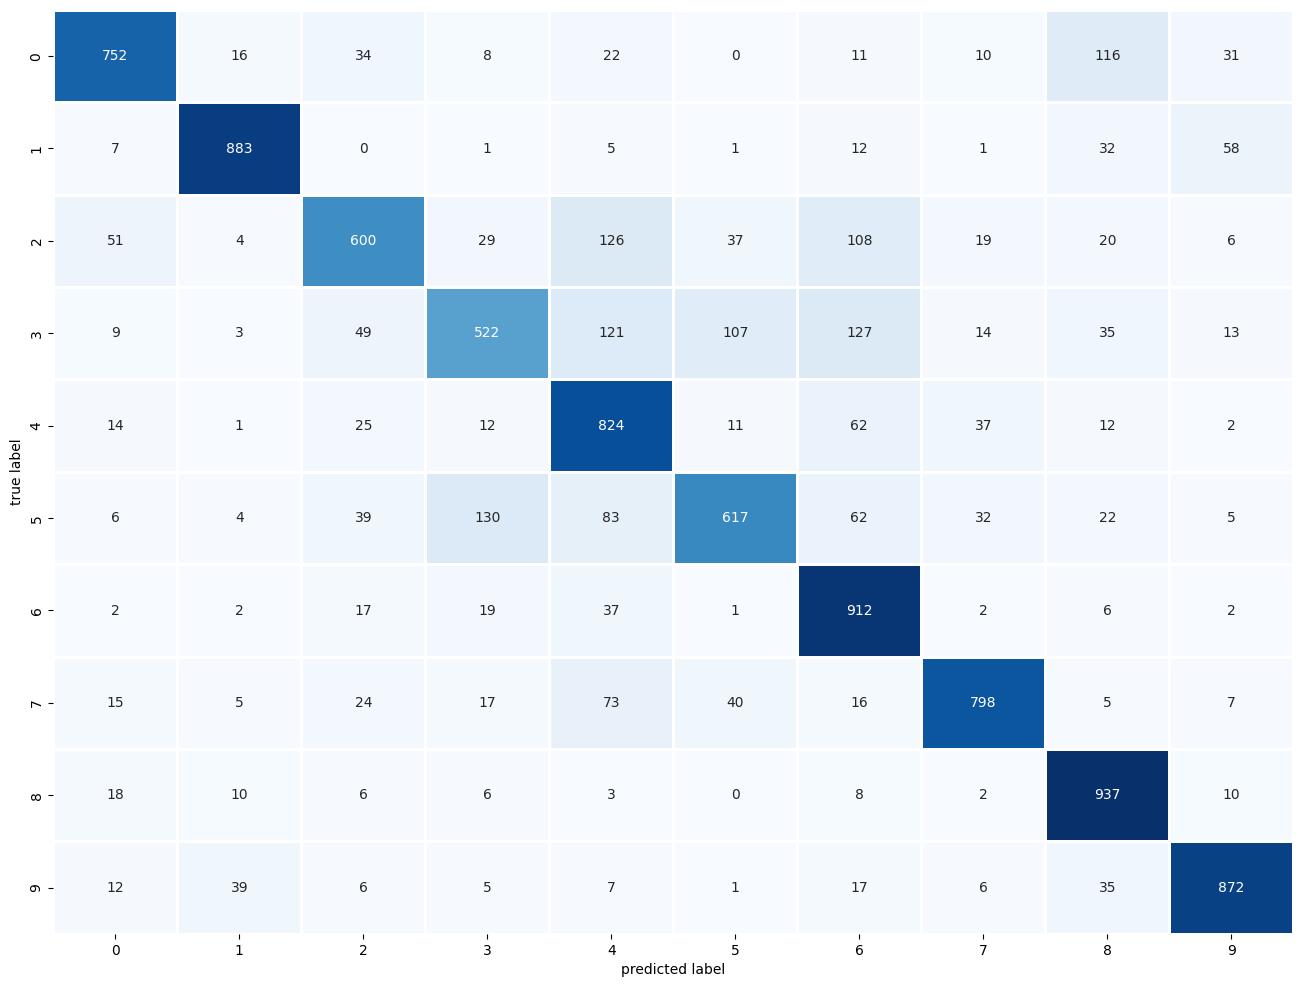

In [193]:
plot_confusion_matrix(y_test,pred11_cm)

In [194]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(pred11[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [195]:
layer_names = []
for layer in model_11.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1',
 'batch_normalization_1',
 'dropout_4',
 'dense_2']

In [196]:
# Extracts the outputs of the top 11 layers:
layer_outputs_11 = [layer.output for layer in model_11.layers[:14]]
# Creates a model that will return these outputs, given the model input:
activation_model_11 = tf.keras.models.Model(inputs=model_11.input, outputs=layer_outputs_11)

# Get activation values for the last dense layer
# activations_11 = activation_model_11.predict(x_valid_norm[:3250])
activations_11 = activation_model_11.predict(x_valid_norm[:1200])
dense_layer_activations_11 = activations_11[-4]
output_layer_activations_11 = activations_11[-1]

38/38 [==============================] - 0s 1ms/step


In [197]:
activations_11[-3].shape

(1200, 384)

## sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [198]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_11 = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results_11 = tsne_11.fit_transform(dense_layer_activations_11)

# Scaling
tsne_results_11 = (tsne_results_11 - tsne_results_11.min()) / (tsne_results_11.max() - tsne_results_11.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 7.921385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.436398
[t-SNE] KL divergence after 300 iterations: 1.002880


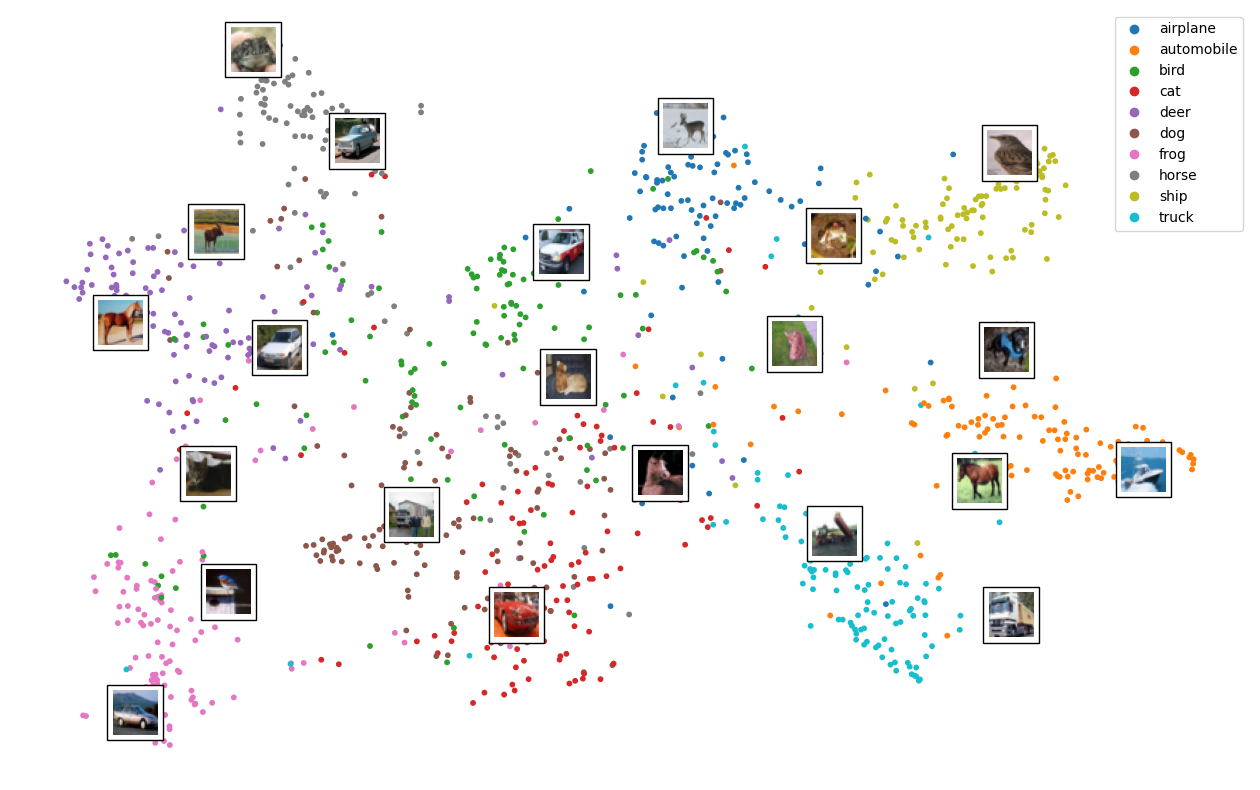

In [201]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results_11[:,0],tsne_results_11[:,1], c=y_valid[:3250], s=10, cmap=cmap)
scatter = plt.scatter(tsne_results_11[:,0],tsne_results_11[:,1], c=y_valid_split[:1200], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_11):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

**Result1**:  Create a table with the accuracy and loss for train/test/validation & process time for ALL the models.

In [204]:
# Convert the dictionary to a DataFrame
resultDf = pd.DataFrame(results).T
# Replace '\n' with '<br>' in the architecture details
resultDf['Architecture'] = resultDf['Architecture'].str.replace('\n', '<br>')

In [205]:
# Display the table with proper HTML rendering for line breaks
display(HTML(resultDf.to_html(escape=False)))